In [1]:
print(f"Figuring Diffusion Modesl by Varit Kobutra")
print(f"Prepared for Prof. Patricia McManus - ITAI2376")

Figuring Diffusion Modesl by Varit Kobutra
Prepared for Prof. Patricia McManus - ITAI2376


# 🎯 Objectives
- Understand the theory and mathematics behind diffusion models
- Implement a U-Net neural network architecture for image generation
- Train a generative model using a progressive noise-adding and noise-removing process
- Analyze and evaluate the quality of AI-generated images
- Apply AI evaluation techniques using CLIP (Contrastive Language-Image Pre-training)

## 💬 Reason for seperate notebook
The provided notebook seemed to be created for implementing the MNIST dataset (0-9 handwritten numbers). I've chosen to create a new notebook to implement the CIFAR-10 Dataset with the A100 GPU. I'll attempt to follow the guidelines outlined in the provided notebook, while achieving the assigned objectives.

# Dataset Setup and Preparation (15%)
- Load and configure your chosen dataset (MNIST, Fashion-MNIST, or CIFAR-10)
- Implement data preprocessing and train-validation splitting
- Create appropriate data loaders

## Imports

In [2]:
# Core PyTorch libraries
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split

# For visualization (optional but recommended)
import matplotlib.pyplot as plt
import numpy as np

print(f"PyTorch Version: {torch.__version__}")
print(f"Torchvision Version: {torchvision.__version__}")

# Check for GPU availability (relevant for Colab)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU Name: {torch.cuda.get_device_name(0)}")


PyTorch Version: 2.6.0+cu124
Torchvision Version: 0.21.0+cu124
Using device: cuda
GPU Name: NVIDIA A100-SXM4-40GB


**Explanation**: This cell imports all the necessary libraries. We import `PyTorch`, `Torchvision` (for datasets and transforms), and specific components from `torch.utils.data`. We also import `matplotlib` and `numpy` for potential visualization later. Finally, it prints the library versions and checks if a GPU is available, which is crucial for training deep learning models efficiently.

## Configuration and Hyperparameters

In [3]:
# --- Configuration ---
DATASET_PATH = "./data" # Directory to download/load CIFAR-10
BATCH_SIZE = 128       # Batch size for training and validation
IMG_SIZE = 32          # CIFAR-10 images are 32x32
N_CHANNELS = 3         # CIFAR-10 has 3 color channels (RGB)
VAL_SPLIT = 0.1        # Proportion of training data to use for validation (e.g., 10%)
NUM_WORKERS = 2        # Number of subprocesses for data loading (adjust based on system)
PIN_MEMORY = True      # Speeds up host-to-device transfer if using GPU

# --- Reproducibility ---
# Setting a seed for reproducibility is good practice
SEED = 42
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)


**Explanation**: We define key hyperparameters and configuration settings here.
* `DATASET_PATH`: Where CIFAR-10 will be stored.
* `BATCH_SIZE`: How many images are processed in one iteration. Adjust based on GPU memory (A100 can handle larger batches than T4). Start with 64 or 128 for T4.
* `IMG_SIZE`, `N_CHANNELS`: Specific to CIFAR-10.
* `VAL_SPLIT`: We'll reserve 10% of the original training data for validation.
* `NUM_WORKERS`, `PIN_MEMORY`: Optimize data loading performance, especially with GPUs.
* `SEED`: Ensures that operations like the train/validation split are the same each time you run the notebook.



## Data Transforms

In [4]:
# Define the transformations for the dataset
# Diffusion models often work best with data normalized to [-1, 1]
# 1. Convert images to PyTorch Tensors (scales pixels to [0, 1])
# 2. Normalize the tensor image with mean and standard deviation to get [-1, 1] range
#    For [0, 1] -> [-1, 1]: Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))

# Transforms for the training set (include augmentation)
train_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(), # Augmentation: randomly flip images horizontally
    transforms.ToTensor(),             # Convert PIL Image to tensor (HWC -> CHW) and scale to [0, 1]
    transforms.Normalize(mean=[0.5] * N_CHANNELS, std=[0.5] * N_CHANNELS) # Normalize to [-1, 1]
])

# Transforms for the validation set (no augmentation)
val_transforms = transforms.Compose([
    transforms.ToTensor(),             # Convert PIL Image to tensor and scale to [0, 1]
    transforms.Normalize(mean=[0.5] * N_CHANNELS, std=[0.5] * N_CHANNELS) # Normalize to [-1, 1]
])

print("Data transforms defined.")


Data transforms defined.


## Load Dataset and Split

In [5]:
# Load the full CIFAR-10 training dataset
# We apply the *training* transforms initially, as random_split doesn't change the data itself,
# only creates subsets. The validation subset will effectively ignore the augmentation part
# when accessed through its specific DataLoader later (or we could define separate datasets).
# A cleaner way is often to load without transforms, split, then apply transforms,
# but this approach is also common and works. Let's refine this slightly.

# Load the dataset *without* specific train/val transforms first
base_dataset = torchvision.datasets.CIFAR10(
    root=DATASET_PATH,
    train=True,
    download=True,
    transform=None # Apply transforms *after* splitting
)

# Calculate split sizes
n_data = len(base_dataset)
n_val = int(n_data * VAL_SPLIT)
n_train = n_data - n_val

print(f"Total training samples: {n_data}")
print(f"Splitting into {n_train} train and {n_val} validation samples...")

# Perform the split using a fixed generator for reproducibility
generator = torch.Generator().manual_seed(SEED)
train_subset_indices, val_subset_indices = random_split(
    range(n_data), [n_train, n_val], generator=generator
)

# Create wrapper datasets to apply the correct transforms
class TransformedDataset(torch.utils.data.Dataset):
    def __init__(self, subset, transform):
        self.subset = subset
        self.transform = transform

    def __getitem__(self, index):
        x, y = self.subset[index]
        if self.transform:
            x = self.transform(x)
        # Diffusion models often only need the image, not the label (y)
        # Return only x, or (x, y) if your model uses conditioning
        return x # Return only image for unconditional diffusion

    def __len__(self):
        return len(self.subset)

# Create datasets with the appropriate transforms applied
# Need to access the underlying data using the indices from random_split
# Re-load the dataset or use Subset class carefully
# Let's use torch.utils.data.Subset and apply transforms within the DataLoader or a wrapper

# Load the *original* dataset again, this time specifying transforms
# This is slightly redundant but ensures transforms are applied correctly per split
train_dataset_raw = torchvision.datasets.CIFAR10(
    root=DATASET_PATH, train=True, download=False, transform=train_transforms
)
val_dataset_raw = torchvision.datasets.CIFAR10(
    root=DATASET_PATH, train=True, download=False, transform=val_transforms
)

# Use Subset to select the data points for each split based on indices
train_dataset = torch.utils.data.Subset(train_dataset_raw, train_subset_indices.indices)
val_dataset = torch.utils.data.Subset(val_dataset_raw, val_subset_indices.indices)


print(f"Created Train dataset with {len(train_dataset)} samples.")
print(f"Created Validation dataset with {len(val_dataset)} samples.")

# Load the test dataset (usually only for final evaluation)
test_dataset = torchvision.datasets.CIFAR10(
    root=DATASET_PATH,
    train=False,
    download=True,
    transform=val_transforms # Use validation transforms (no augmentation)
)
print(f"Loaded Test dataset with {len(test_dataset)} samples.")



Total training samples: 50000
Splitting into 45000 train and 5000 validation samples...
Created Train dataset with 45000 samples.
Created Validation dataset with 5000 samples.
Loaded Test dataset with 10000 samples.


## Create DataLoaders

In [6]:
# Create DataLoaders for training and validation sets

train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,          # Shuffle training data each epoch
    num_workers=NUM_WORKERS,
    pin_memory=PIN_MEMORY,
    drop_last=True,         # Drop last incomplete batch if dataset size is not divisible by batch size
    persistent_workers=True if NUM_WORKERS > 0 else False # Adding to optimize clean up process
)

val_loader = DataLoader(
    dataset=val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,         # No need to shuffle validation data
    num_workers=NUM_WORKERS,
    pin_memory=PIN_MEMORY,
    drop_last=False,        # Keep last incomplete batch for validation
    persistent_workers=True if NUM_WORKERS > 0 else False # Adding to optimize clean up process
)

# Create DataLoader for the test set
test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=PIN_MEMORY
)

print(f"Created DataLoader for training with {len(train_loader)} batches.")
print(f"Created DataLoader for validation with {len(val_loader)} batches.")

if 'test_loader' in locals():
    print(f"Created DataLoader for testing with {len(test_loader)} batches.")


Created DataLoader for training with 351 batches.
Created DataLoader for validation with 40 batches.
Created DataLoader for testing with 79 batches.


## Visualize a Batch

Image batch shape: torch.Size([128, 3, 32, 32])
Labels batch shape: torch.Size([128])
Image data range: Min=-1.00, Max=1.00


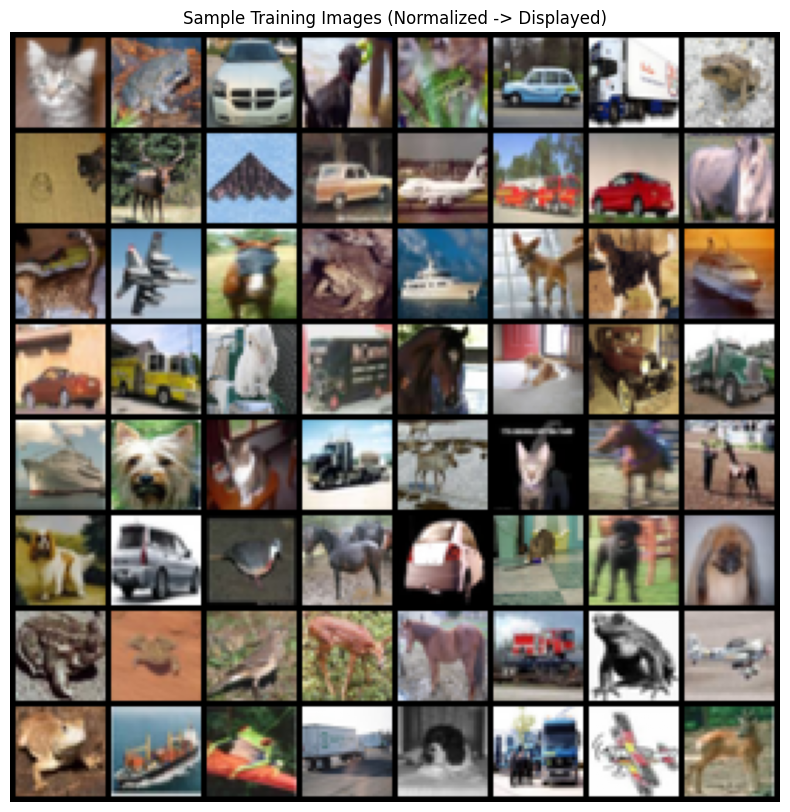

In [7]:
# Function to display images
def show_images(images, title=""):
    """Shows the first few images from a batch."""
    if isinstance(images, torch.Tensor):
        # Ensure tensor is on CPU and detach from computation graph
        images = images.detach().cpu()
        # Denormalize images from [-1, 1] to [0, 1] for display
        images = images * 0.5 + 0.5
        # Make a grid (add padding for better visualization)
        grid = torchvision.utils.make_grid(images, nrow=8, padding=2, normalize=False) # nrow=8 for ~64 images
        np_image = grid.numpy()
        # Transpose from (C, H, W) to (H, W, C) for matplotlib
        plt.figure(figsize=(10, 10))
        plt.imshow(np.transpose(np_image, (1, 2, 0)))
        plt.title(title)
        plt.axis("off")
        plt.show()
    else:
        print("Input is not a valid tensor.")

# Fetch a batch of training images
try:
    # DataLoaders return (image, label) tuples from CIFAR10 dataset
    # We only need the images for visualization here
    images, labels = next(iter(train_loader))
    print(f"Image batch shape: {images.shape}") # Should be [BATCH_SIZE, N_CHANNELS, IMG_SIZE, IMG_SIZE]
    print(f"Labels batch shape: {labels.shape}") # Should be [BATCH_SIZE]
    print(f"Image data range: Min={torch.min(images):.2f}, Max={torch.max(images):.2f}") # Should be approx [-1, 1]

    # Show the first 64 images from the batch
    show_images(images[:64], title="Sample Training Images (Normalized -> Displayed)")
except StopIteration:
    print("DataLoader is empty or could not fetch a batch.")
except Exception as e:
    print(f"An error occurred during visualization: {e}")



# Model Architecture Components (25%)
- Complete the implementation of the GELUConvBlock, UpBlock, and other - architectural components
- Implement the UNet forward function with proper skip connections
- Add time and class conditioning mechanisms

## Time Embedding

In [8]:
import torch
import torch.nn as nn
import math

class SinusoidalPositionEmbeddings(nn.Module):
    """Computes sinusoidal embeddings for time steps."""
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        """
        Args:
            time (torch.Tensor): A 1-D tensor of time steps, shape (batch_size,).

        Returns:
            torch.Tensor: Positional embeddings, shape (batch_size, dim).
        """
        device = time.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        # Ensure time is broadcastable: (batch_size,) -> (batch_size, 1)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        # Zero pad if dim is odd, although usually dim is even
        if self.dim % 2 == 1:
            embeddings = torch.nn.functional.pad(embeddings, (0,1))

        return embeddings

print("SinusoidalPositionEmbeddings module defined.")


SinusoidalPositionEmbeddings module defined.


## Building Blocks
*(Residual Block with Time/Class Embedding)*

In [9]:
import torch.nn.functional as F

class Block(nn.Module):
    """Convolutional block with GroupNorm, SiLU activation, and time/class embedding."""
    def __init__(self, in_channels, out_channels, time_emb_dim, num_groups=8):
        super().__init__()
        # Time/Class embedding projection
        self.time_mlp = nn.Linear(time_emb_dim, out_channels)

        # First convolution layer
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.norm1 = nn.GroupNorm(num_groups, out_channels)
        self.act1 = nn.SiLU() # Swish activation

        # Second convolution layer
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.norm2 = nn.GroupNorm(num_groups, out_channels)
        self.act2 = nn.SiLU()

        # Residual connection
        # If input and output channels differ, use a 1x1 convolution
        if in_channels != out_channels:
            self.residual_conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)
        else:
            self.residual_conv = nn.Identity()

    def forward(self, x, t_emb):
        """
        Args:
            x (torch.Tensor): Input feature map, shape (B, C_in, H, W).
            t_emb (torch.Tensor): Time/Class embedding, shape (B, time_emb_dim).

        Returns:
            torch.Tensor: Output feature map, shape (B, C_out, H, W).
        """
        # --- First Conv Layer ---
        h = self.act1(self.norm1(self.conv1(x)))

        # --- Incorporate Time/Class Embedding ---
        # Project time embedding and reshape for broadcasting: (B, C_out) -> (B, C_out, 1, 1)
        time_bias = self.time_mlp(t_emb).unsqueeze(-1).unsqueeze(-1)
        h = h + time_bias # Add time bias

        # --- Second Conv Layer ---
        h = self.act2(self.norm2(self.conv2(h)))

        # --- Residual Connection ---
        residual = self.residual_conv(x)
        out = h + residual

        return out

print("Block module defined.")



Block module defined.


## Downsampling and Upsampling Blocks

In [10]:
class DownBlock(nn.Module):
    """Downsampling block composed of two Blocks and a MaxPool."""
    def __init__(self, in_channels, out_channels, time_emb_dim, num_groups=8):
        super().__init__()
        # Define blocks individually instead of using nn.Sequential
        self.block1 = Block(in_channels, out_channels, time_emb_dim, num_groups)
        self.block2 = Block(out_channels, out_channels, time_emb_dim, num_groups)

        # Using MaxPool for simplicity, could use strided convolution
        self.downsample = nn.MaxPool2d(2)
        # Alternative: self.downsample = nn.Conv2d(out_channels, out_channels, kernel_size=4, stride=2, padding=1)


    def forward(self, x, t_emb):
        """
        Args:
            x (torch.Tensor): Input feature map.
            t_emb (torch.Tensor): Time/Class embedding.

        Returns:
            Tuple[torch.Tensor, torch.Tensor]: (Output after downsampling, Output before downsampling for skip connection).
        """
        # Call blocks explicitly, passing t_emb to each
        x = self.block1(x, t_emb)
        x = self.block2(x, t_emb)

        skip_connection = x           # Save output for skip connection
        x = self.downsample(x)        # Downsample
        return x, skip_connection

class UpBlock(nn.Module):
    """Upsampling block composed of Upsample, Concatenation, and two Blocks."""
    def __init__(self, in_channels, skip_channels, out_channels, time_emb_dim, num_groups=8):
        super().__init__()
        # Upsample layer (could use ConvTranspose2d as well)
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False)
        # Input to residual blocks has channels from upsampled input + skip connection
        combined_channels = in_channels + skip_channels

        # Define blocks individually
        self.block1 = Block(combined_channels, out_channels, time_emb_dim, num_groups)
        self.block2 = Block(out_channels, out_channels, time_emb_dim, num_groups)


    def forward(self, x, skip_connection, t_emb):
        """
        Args:
            x (torch.Tensor): Input feature map from the previous layer in the up path.
            skip_connection (torch.Tensor): Feature map from the corresponding down path layer.
            t_emb (torch.Tensor): Time/Class embedding.

        Returns:
            torch.Tensor: Output feature map.
        """
        x = self.upsample(x) # Upsample
        # Concatenate along the channel dimension
        x = torch.cat([x, skip_connection], dim=1) # dim=1 for channels (B, C, H, W)

        # Call blocks explicitly, passing t_emb to each
        x = self.block1(x, t_emb)
        x = self.block2(x, t_emb)
        return x

print("DownBlock and UpBlock modules redefined.")


DownBlock and UpBlock modules redefined.


## U-Net Model

In [11]:
import torch
import torch.nn as nn
import math
import torch.nn.functional as F

# Make sure SinusoidalPositionEmbeddings and Block are defined above this cell
# (Or include them again if running standalone)

# class SinusoidalPositionEmbeddings(nn.Module): ... (from Cell 7)
# class Block(nn.Module): ... (from Cell 8)
# class DownBlock(nn.Module): ... (from revised Cell 9)
# class UpBlock(nn.Module): ... (from revised Cell 9)


class UNet(nn.Module):
    """Simple U-Net architecture for Diffusion Model."""
    def __init__(
        self,
        in_channels=3,
        out_channels=3,
        base_dim=64,
        dim_mults=(1, 2, 4),
        time_emb_dim=256,
        num_classes=None,
        num_groups=8
    ):
        super().__init__()

        self.num_classes = num_classes
        self.time_emb_dim_internal = base_dim * 4

        # --- Time Embedding Projection ---
        self.time_embeddings = SinusoidalPositionEmbeddings(base_dim)
        self.time_mlp = nn.Sequential(
            nn.Linear(base_dim, self.time_emb_dim_internal),
            nn.SiLU(),
            nn.Linear(self.time_emb_dim_internal, time_emb_dim)
        )

        # --- Class Embedding (Optional) ---
        if num_classes is not None:
            self.class_embeddings = nn.Embedding(num_classes, base_dim)
            print(f"U-Net configured for class conditioning with {num_classes} classes.")
        else:
            self.class_embeddings = None
            print("U-Net configured for unconditional generation.")

        # --- Initial Convolution ---
        self.init_conv = nn.Conv2d(in_channels, base_dim, kernel_size=3, padding=1)

        # --- Calculate Dimensions ---
        # Example: base_dim=64, dim_mults=(1, 2, 4)
        # dims = [64, 64, 128, 256]
        dims = [base_dim] + [base_dim * m for m in dim_mults]
        in_out_dims = list(zip(dims[:-1], dims[1:])) # [(64, 64), (64, 128), (128, 256)]

        # --- Downsampling Path ---
        self.down_blocks = nn.ModuleList()
        current_dim = base_dim
        for i, (dim_in, dim_out) in enumerate(in_out_dims):
            self.down_blocks.append(
                DownBlock(current_dim, dim_out, time_emb_dim, num_groups)
            )
            current_dim = dim_out # Update current_dim based on DownBlock output

        # --- Bottleneck ---
        # current_dim is now dims[-1] (e.g., 256)
        self.bottleneck1 = Block(current_dim, current_dim, time_emb_dim, num_groups)
        self.bottleneck2 = Block(current_dim, current_dim, time_emb_dim, num_groups)

        # --- Upsampling Path ---
        self.up_blocks = nn.ModuleList()
        # The skip connections will have channels corresponding to the *output* of the DownBlocks
        # Output dims of DownBlocks were dims[1:] = [64, 128, 256]
        # In reverse order for upsampling: [256, 128, 64]
        skip_connection_dims = list(reversed(dims[1:]))

        # The output dimensions of the UpBlocks should symmetrically decrease
        # Output dims we want: [128, 64, 64] (i.e., dims[:-1] reversed)
        upblock_out_dims = list(reversed(dims[:-1]))

        # current_dim starts at bottleneck output dim (e.g., 256)
        for i in range(len(dim_mults)):
            skip_channels = skip_connection_dims[i] # Channels from corresponding DownBlock skip
            out_channels_up = upblock_out_dims[i]   # Desired output channels for this UpBlock

            self.up_blocks.append(
                UpBlock(
                    in_channels=current_dim,    # Channels from previous layer in Up path
                    skip_channels=skip_channels,# Actual channels from skip connection
                    out_channels=out_channels_up, # Desired output channels
                    time_emb_dim=time_emb_dim,
                    num_groups=num_groups
                )
            )
            # Update current_dim for the next UpBlock
            current_dim = out_channels_up

        # --- Final Convolution ---
        # current_dim should now be the output dim of the last UpBlock (e.g., 64)
        self.final_conv = nn.Conv2d(current_dim, out_channels, kernel_size=1)


    def forward(self, x, time, class_labels=None):
        # (Forward pass remains the same as the previous revision)
        # 1. Input Checks
        if self.num_classes is not None and class_labels is None:
            raise ValueError("Class labels must be provided when num_classes is set.")
        if self.num_classes is None and class_labels is not None:
            print("Warning: Class labels provided but num_classes is None. Labels will be ignored.")

        # 2. Time Embedding
        t_emb = self.time_embeddings(time)

        # 3. Class Embedding (Optional)
        if self.class_embeddings is not None:
            c_emb = self.class_embeddings(class_labels)
            t_emb = t_emb + c_emb

        # Project combined embedding through MLP
        t_emb = self.time_mlp(t_emb)

        # 4. Initial Convolution
        x = self.init_conv(x)

        # 5. Downsampling Path
        skip_connections = []
        for down_block in self.down_blocks:
            x, skip = down_block(x, t_emb)
            skip_connections.append(skip)

        # 6. Bottleneck
        x = self.bottleneck1(x, t_emb)
        x = self.bottleneck2(x, t_emb)

        # 7. Upsampling Path
        for up_block, skip in zip(self.up_blocks, reversed(skip_connections)):
            x = up_block(x, skip, t_emb)

        # 8. Final Convolution
        out = self.final_conv(x)

        return out

print("UNet module redefined with corrected UpBlock initialization.")


UNet module redefined with corrected UpBlock initialization.


# Verification
Before diving into the complexities of the diffusion process (noise schedules, sampling steps, loss calculation), it's highly beneficial to run a few checks to ensure the data pipeline and the U-Net model interact correctly. This can save a lot of debugging time later.

## Example Instantiation and Forward Pass Check

In [12]:
# --- Configuration (should match data setup) ---
IMG_SIZE = 32
N_CHANNELS = 3
BATCH_SIZE = 4 # Use a small batch for testing

# --- Model Hyperparameters ---
unet_base_dim = 64
unet_dim_mults = (1, 2, 4) # Results in dims: 64, 128, 256
unet_time_emb_dim = 256    # Should match time_emb_dim in Blocks
unet_num_classes = 10      # For CIFAR-10 conditioning
# unet_num_classes = None    # For unconditional model

# --- Instantiate Model ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = UNet(
    in_channels=N_CHANNELS,
    out_channels=N_CHANNELS,
    base_dim=unet_base_dim,
    dim_mults=unet_dim_mults,
    time_emb_dim=unet_time_emb_dim,
    num_classes=unet_num_classes,
    num_groups=8 # Consistent group norm parameter
).to(device)

print(f"U-Net instantiated on {device}.")
# print(model) # Optional: Print model layers

# --- Create Dummy Input ---
dummy_x = torch.randn(BATCH_SIZE, N_CHANNELS, IMG_SIZE, IMG_SIZE, device=device)
dummy_time = torch.randint(0, 1000, (BATCH_SIZE,), device=device).long() # Example time steps
dummy_labels = None
if unet_num_classes is not None:
    dummy_labels = torch.randint(0, unet_num_classes, (BATCH_SIZE,), device=device).long()

# --- Perform Forward Pass ---
try:
    with torch.no_grad(): # No need to compute gradients for this check
        output = model(dummy_x, dummy_time, dummy_labels)
    print(f"Input shape: {dummy_x.shape}")
    print(f"Time shape: {dummy_time.shape}")
    if dummy_labels is not None:
        print(f"Labels shape: {dummy_labels.shape}")
    print(f"Output shape: {output.shape}")

    # Check if output shape matches input shape
    assert output.shape == dummy_x.shape
    print("Forward pass successful, output shape matches input shape.")

except Exception as e:
    print(f"An error occurred during the forward pass check: {e}")
    import traceback
    traceback.print_exc()

# --- Count Parameters (Optional) ---
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total trainable parameters: {num_params:,}")



U-Net configured for class conditioning with 10 classes.
U-Net instantiated on cuda.
Input shape: torch.Size([4, 3, 32, 32])
Time shape: torch.Size([4])
Labels shape: torch.Size([4])
Output shape: torch.Size([4, 3, 32, 32])
Forward pass successful, output shape matches input shape.
Total trainable parameters: 7,283,523


## Data Loader and Batch Verification

In [13]:
# --- Fetch a single batch from the train_loader ---
try:
    # Use iter and next to get one batch
    batch_images, batch_labels = next(iter(train_loader))
    print("Successfully fetched one batch from train_loader.")

    # --- Check Shapes ---
    print(f"Batch Images Shape: {batch_images.shape}")
    # Expected: [BATCH_SIZE, N_CHANNELS, IMG_SIZE, IMG_SIZE] (e.g., [128, 3, 32, 32])
    print(f"Batch Labels Shape: {batch_labels.shape}")
    # Expected: [BATCH_SIZE] (e.g., [128])

    # --- Check Data Type ---
    print(f"Batch Images dtype: {batch_images.dtype}")
    # Expected: torch.float32
    print(f"Batch Labels dtype: {batch_labels.dtype}")
    # Expected: torch.int64 (or torch.long)

    # --- Check Value Range (Normalization) ---
    min_val = torch.min(batch_images)
    max_val = torch.max(batch_images)
    print(f"Batch Images Value Range: Min={min_val:.4f}, Max={max_val:.4f}")
    # Expected: Approximately within [-1.0, 1.0]

    # --- Check Device ---
    print(f"Batch Images Device: {batch_images.device}")
    print(f"Batch Labels Device: {batch_labels.device}")
    # Expected: 'cpu' initially, unless DataLoader moves it (unlikely by default)

    # --- Move batch to the model's device for the next check ---
    batch_images = batch_images.to(device)
    batch_labels = batch_labels.to(device)
    print(f"Batch moved to device: {batch_images.device}")

except StopIteration:
    print("ERROR: train_loader is empty. Check dataset/split.")
except Exception as e:
    print(f"ERROR fetching/checking batch: {e}")
    import traceback
    traceback.print_exc()



Successfully fetched one batch from train_loader.
Batch Images Shape: torch.Size([128, 3, 32, 32])
Batch Labels Shape: torch.Size([128])
Batch Images dtype: torch.float32
Batch Labels dtype: torch.int64
Batch Images Value Range: Min=-1.0000, Max=1.0000
Batch Images Device: cpu
Batch Labels Device: cpu
Batch moved to device: cuda:0


## Model Forward Pass with Real Data

In [14]:
# --- Ensure model exists and is on the correct device ---
if 'model' not in locals():
    print("ERROR: Model not defined. Please run the U-Net definition cell (Cell 10).")
elif batch_images is None:
     print("ERROR: Batch not loaded. Please run the previous cell (Cell 12).")
else:
    print(f"Model is on device: {next(model.parameters()).device}")
    print(f"Input batch is on device: {batch_images.device}")

    # --- Generate Dummy Time Steps ---
    # Diffusion models typically use time steps from 0 to T (e.g., 1000)
    num_timesteps_example = 1000
    dummy_time = torch.randint(
        0, num_timesteps_example, (batch_images.shape[0],), device=device
    ).long()
    print(f"Dummy Time Steps Shape: {dummy_time.shape}, Device: {dummy_time.device}")

    # --- Prepare Class Labels (if using conditioning) ---
    forward_labels = None
    if model.num_classes is not None:
        forward_labels = batch_labels # Use the real labels from the batch
        print(f"Using real labels for conditioning. Shape: {forward_labels.shape}, Device: {forward_labels.device}")
    else:
        print("Model is unconditional, not using labels.")


    # --- Perform Forward Pass ---
    try:
        # Use torch.no_grad() as we don't need gradients here yet
        with torch.no_grad():
            model_output = model(batch_images, dummy_time, forward_labels)

        print("\n--- Forward Pass Successful ---")
        print(f"Model Input Shape:  {batch_images.shape}")
        print(f"Model Output Shape: {model_output.shape}")
        print(f"Model Output Device: {model_output.device}")

        # --- Check Output Shape ---
        assert model_output.shape == batch_images.shape, "Output shape mismatch!"
        print("Output shape matches input image shape.")

        # --- Check Output Value Range (Optional but informative) ---
        min_out = torch.min(model_output)
        max_out = torch.max(model_output)
        print(f"Model Output Value Range: Min={min_out:.4f}, Max={max_out:.4f}")
        # Expected: Should be reasonable floats, not NaN or Inf.

    except Exception as e:
        print(f"\nERROR during model forward pass: {e}")
        import traceback
        traceback.print_exc()



Model is on device: cuda:0
Input batch is on device: cuda:0
Dummy Time Steps Shape: torch.Size([128]), Device: cuda:0
Using real labels for conditioning. Shape: torch.Size([128]), Device: cuda:0

--- Forward Pass Successful ---
Model Input Shape:  torch.Size([128, 3, 32, 32])
Model Output Shape: torch.Size([128, 3, 32, 32])
Model Output Device: cuda:0
Output shape matches input image shape.
Model Output Value Range: Min=-3.5894, Max=2.8964


## Basic Gradient Check (Dummy Loss)

In [15]:
# --- Ensure model and input batch exist ---
if 'model' not in locals():
    print("ERROR: Model not defined. Please run the U-Net definition cell (Cell 10/17).")
elif 'batch_images' not in locals() or batch_images is None:
     print("ERROR: Batch not loaded. Please run the data loading cell (Cell 12).")
else:
    print("\n--- Starting Gradient Check ---")

    # --- Ensure data is on the correct device ---
    # (Should already be done in Cell 12, but double-check)
    if batch_images.device != device: batch_images = batch_images.to(device)
    if batch_labels.device != device: batch_labels = batch_labels.to(device)

    # --- Generate Dummy Time Steps (same as Cell 13) ---
    num_timesteps_example = 1000
    dummy_time = torch.randint(
        0, num_timesteps_example, (batch_images.shape[0],), device=device
    ).long()

    # --- Prepare Class Labels (if using conditioning - same as Cell 13) ---
    forward_labels = None
    if model.num_classes is not None:
        forward_labels = batch_labels
    else:
        # Ensure labels are None if model is unconditional
        forward_labels = None

    # --- Perform Forward Pass *WITH GRADIENT TRACKING* ---
    # Make sure model is in training mode if it has layers like Dropout/BatchNorm
    # that behave differently during training vs evaluation. For this basic check,
    # it might not matter, but it's good practice.
    # model.train() # uncomment if needed

    try:
        # Run the forward pass *without* torch.no_grad()
        model_output = model(batch_images, dummy_time, forward_labels)
        print(f"Forward pass for gradient check successful. Output shape: {model_output.shape}")

        # --- Create a Dummy Target ---
        dummy_target = torch.randn_like(model_output, device=device)
        print(f"Dummy Target Shape: {dummy_target.shape}, Device: {dummy_target.device}")

        # --- Define a Simple Loss ---
        loss_fn = nn.MSELoss()
        loss = loss_fn(model_output, dummy_target)
        print(f"Calculated Dummy Loss: {loss.item():.4f}")

        # --- Check if loss requires grad ---
        if not loss.requires_grad:
             raise RuntimeError("Loss does not require grad! Check model parameters or forward pass.")
        print(f"Loss requires_grad: {loss.requires_grad}, grad_fn: {loss.grad_fn}")


        # --- Perform Backward Pass ---
        # Zero gradients before backward pass
        model.zero_grad()
        loss.backward()
        print("loss.backward() executed successfully.")

        # --- Check for Gradients in Key Layers ---
        grad_check_params = {
            "init_conv": model.init_conv.weight.grad,
            "final_conv": model.final_conv.weight.grad,
            "down_block_0_conv1": model.down_blocks[0].block1.conv1.weight.grad, # Adjusted path after removing Sequential
            "bottleneck_1_conv1": model.bottleneck1.conv1.weight.grad, # Adjusted path
            "up_block_0_conv1": model.up_blocks[0].block1.conv1.weight.grad, # Adjusted path
        }

        all_grads_exist = True
        for name, grad in grad_check_params.items():
            if grad is None:
                print(f"WARNING: Gradient for '{name}' is None.")
                all_grads_exist = False
            else:
                grad_abs_sum = torch.sum(torch.abs(grad))
                print(f"Gradient for '{name}' exists. Abs Sum: {grad_abs_sum:.4e}")
                if grad_abs_sum == 0:
                     print(f"WARNING: Gradient for '{name}' is all zeros.")

        if all_grads_exist:
            print("Basic gradient check passed: Gradients exist for checked parameters.")
        else:
            print("Gradient check failed: Some parameters have no gradients.")

        # --- Clean up gradients after check ---
        model.zero_grad()
        # model.eval() # Optional: Set back to eval mode if you used model.train()

    except Exception as e:
        print(f"\nERROR during backward pass or gradient check: {e}")
        import traceback
        traceback.print_exc()




--- Starting Gradient Check ---
Forward pass for gradient check successful. Output shape: torch.Size([128, 3, 32, 32])
Dummy Target Shape: torch.Size([128, 3, 32, 32]), Device: cuda:0
Calculated Dummy Loss: 1.3424
Loss requires_grad: True, grad_fn: <MseLossBackward0 object at 0x79e7ae5b6e30>
loss.backward() executed successfully.
Gradient for 'init_conv' exists. Abs Sum: 1.8706e+01
Gradient for 'final_conv' exists. Abs Sum: 2.3454e+01
Gradient for 'down_block_0_conv1' exists. Abs Sum: 3.1247e+02
Gradient for 'bottleneck_1_conv1' exists. Abs Sum: 4.8624e+02
Gradient for 'up_block_0_conv1' exists. Abs Sum: 1.8523e+03
Basic gradient check passed: Gradients exist for checked parameters.


# Diffusion Process Implementation (20%)
- Complete the forward diffusion process (adding noise)
- Implement the reverse diffusion process (removing noise)
- Create the training step function

## Diffusion Constants and Noise Schedule

In [16]:
import torch
import torch.nn.functional as F

# --- Diffusion Hyperparameters ---
TIMESTEPS = 1000            # Number of diffusion steps
BETA_START = 0.0001        # Starting variance schedule value
BETA_END = 0.02            # Ending variance schedule value

# --- Define Beta Schedule ---
# We'll use a linear schedule, common in DDPMs
betas = torch.linspace(BETA_START, BETA_END, TIMESTEPS, device=device)

# --- Precompute Diffusion Quantities ---
# These are derived from the betas and used in the equations
alphas = 1. - betas                                          # alpha_t = 1 - beta_t
alphas_cumprod = torch.cumprod(alphas, axis=0)               # alpha_bar_t = product(alpha_i for i=1..t)
alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.0) # alpha_bar_{t-1}

# Quantities needed for forward process q(x_t | x_0)
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)             # sqrt(alpha_bar_t)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - alphas_cumprod) # sqrt(1 - alpha_bar_t)

# Quantities needed for reverse process q(x_{t-1} | x_t, x_0) (used in sampling, not directly in this loss)
# posterior_variance = betas * (1. - alphas_cumprod_prev) / (1. - alphas_cumprod) # beta_tilde_t

print("Diffusion constants and schedule precomputed.")
print(f"betas shape: {betas.shape}")
print(f"alphas_cumprod shape: {alphas_cumprod.shape}")
print(f"sqrt_alphas_cumprod shape: {sqrt_alphas_cumprod.shape}")
print(f"sqrt_one_minus_alphas_cumprod shape: {sqrt_one_minus_alphas_cumprod.shape}")

# --- Helper function to extract values for a batch of timesteps ---
def extract(a, t, x_shape):
    """
    Extracts values from tensor 'a' at indices 't' and reshapes for broadcasting.

    Args:
        a (torch.Tensor): Tensor to extract from (e.g., sqrt_alphas_cumprod).
        t (torch.Tensor): Timestep indices, shape (batch_size,).
        x_shape (torch.Size): Shape of the target tensor (e.g., image batch).

    Returns:
        torch.Tensor: Extracted values reshaped to (batch_size, 1, 1, 1).
    """
    batch_size = t.shape[0]
    # Use gather to get the values corresponding to the timesteps t
    out = a.gather(-1, t)
    # Reshape to match the dimensions of the image batch for broadcasting
    # (batch_size,) -> (batch_size, 1, 1, 1)
    return out.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(t.device)

print("Helper function 'extract' defined.")


Diffusion constants and schedule precomputed.
betas shape: torch.Size([1000])
alphas_cumprod shape: torch.Size([1000])
sqrt_alphas_cumprod shape: torch.Size([1000])
sqrt_one_minus_alphas_cumprod shape: torch.Size([1000])
Helper function 'extract' defined.


## Forward Diffusion Process
*(q_sample)*

Forward diffusion function 'q_sample' defined.
Visualizing forward process for Label: 2 (bird)


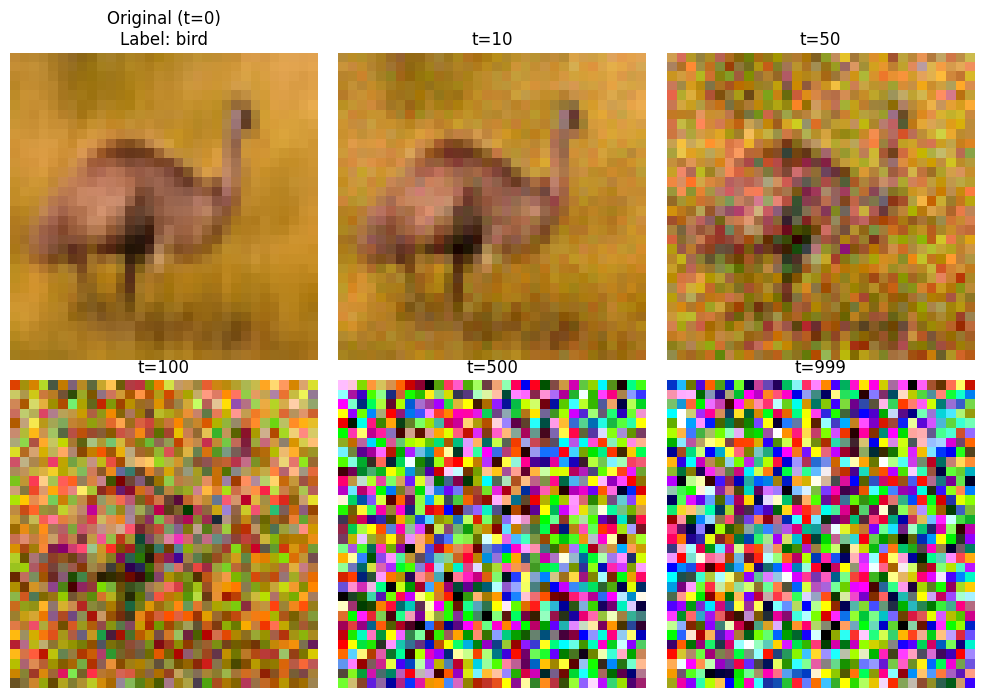

In [17]:
import matplotlib.pyplot as plt # Ensure matplotlib is imported
import numpy as np # Ensure numpy is imported

# --- Forward Process q(x_t | x_0) ---
# (Keep the q_sample function definition from the previous version)
def q_sample(x_start, t, noise=None):
    """
    Diffuses the input image x_start to timestep t.

    Args:
        x_start (torch.Tensor): The initial clean image (x_0), shape (B, C, H, W).
        t (torch.Tensor): Timesteps for each image in the batch, shape (B,).
        noise (torch.Tensor, optional): The noise epsilon ~ N(0, I). If None, noise is generated.
                                        Shape must match x_start.

    Returns:
        torch.Tensor: The noisy image at timestep t (x_t).
    """
    if noise is None:
        noise = torch.randn_like(x_start, device=x_start.device)

    # Ensure t is on the same device as other tensors
    t = t.to(x_start.device)

    # Extract the precomputed values for the given timesteps t
    sqrt_alphas_cumprod_t = extract(sqrt_alphas_cumprod, t, x_start.shape)
    sqrt_one_minus_alphas_cumprod_t = extract(sqrt_one_minus_alphas_cumprod, t, x_start.shape)

    # Apply the forward diffusion formula: x_t = sqrt(alpha_bar_t) * x_0 + sqrt(1 - alpha_bar_t) * noise
    noisy_image = sqrt_alphas_cumprod_t * x_start + sqrt_one_minus_alphas_cumprod_t * noise

    return noisy_image

print("Forward diffusion function 'q_sample' defined.")


# --- Visualize the forward process (Compact Layout with Label) ---
# Define CIFAR-10 class names for better visualization
cifar10_classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
                   'dog', 'frog', 'horse', 'ship', 'truck']

try:
    # Get a single image and its label from the batch loaded earlier (Cell 12)
    if ('batch_images' in locals() and batch_images is not None and
        'batch_labels' in locals() and batch_labels is not None):

        image_index_to_show = 0 # Choose which image from the batch to display
        single_image = batch_images[image_index_to_show].unsqueeze(0).to(device) # Add batch dim, move to device
        single_label_index = batch_labels[image_index_to_show].item() # Get label index as Python int
        single_label_name = cifar10_classes[single_label_index] # Get class name

        print(f"Visualizing forward process for Label: {single_label_index} ({single_label_name})")

        # Define timesteps to visualize
        vis_timesteps = [0, 10, 50, 100, 500, TIMESTEPS - 1]
        num_images_to_show = len(vis_timesteps)

        # Create a 2x3 grid
        fig, axes = plt.subplots(2, 3, figsize=(10, 7)) # Slightly larger figsize for longer titles
        axes = axes.flatten() # Flatten the 2x3 grid into a 1D array

        for i, t_vis in enumerate(vis_timesteps):
            ax = axes[i]
            if t_vis == 0:
                img_to_show = single_image
                # Add label name to the title of the original image
                title = f"Original (t=0)\nLabel: {single_label_name}"
            else:
                t_tensor = torch.tensor([t_vis], device=device).long()
                img_to_show = q_sample(single_image, t_tensor)
                title = f"t={t_vis}"

            # Plotting logic (same as before)
            if isinstance(img_to_show, torch.Tensor):
                img_to_show = img_to_show.squeeze(0) # Remove batch dim
                img_to_show = img_to_show.detach().cpu()
                img_to_show = img_to_show * 0.5 + 0.5 # Denormalize
                img_to_show = img_to_show.clamp(0, 1)
                np_image = img_to_show.numpy()
                ax.imshow(np.transpose(np_image, (1, 2, 0))) # CHW -> HWC
                ax.set_title(title)
                ax.axis("off")
            else:
                ax.text(0.5, 0.5, 'Invalid Image', ha='center', va='center')
                ax.set_title(title)
                ax.axis("off")

        # Hide any unused subplots
        for j in range(num_images_to_show, len(axes)):
            axes[j].axis("off")

        plt.tight_layout()
        plt.show()
    else:
        print("Skipping forward process visualization (batch_images or batch_labels not found).")

except IndexError:
     print(f"Error: Label index {single_label_index} out of range for cifar10_classes list.")
except Exception as e:
    print(f"Error during forward process visualization: {e}")
    import traceback
    traceback.print_exc()


## Loss Calculation and Training Step

In [18]:
# --- Loss Function ---
# Typically Mean Squared Error (MSE) between added noise and predicted noise
loss_fn = nn.MSELoss()
# Alternatives: nn.L1Loss() (Huber loss is also sometimes used)

# --- Reverse Process / Loss Calculation p_losses ---
def p_losses(model, x_start, t, noise=None, loss_type="mse", class_labels=None):
    """
    Calculates the loss for the diffusion model.

    Args:
        model (nn.Module): The U-Net model.
        x_start (torch.Tensor): The initial clean image (x_0).
        t (torch.Tensor): Timesteps for each image in the batch.
        noise (torch.Tensor, optional): The noise epsilon ~ N(0, I) used in q_sample.
                                        If None, noise is generated.
        loss_type (str): Type of loss ('mse' or 'l1').
        class_labels (torch.Tensor, optional): Class labels for conditioning.

    Returns:
        torch.Tensor: The calculated loss scalar.
    """
    if noise is None:
        noise = torch.randn_like(x_start, device=x_start.device)

    # 1. Generate the noisy image x_t using the forward process
    x_noisy = q_sample(x_start=x_start, t=t, noise=noise)

    # 2. Get the model's prediction of the noise
    # Ensure model is on the same device
    model_device = next(model.parameters()).device
    x_noisy = x_noisy.to(model_device)
    t = t.to(model_device)
    if class_labels is not None:
        class_labels = class_labels.to(model_device)

    predicted_noise = model(x_noisy, t, class_labels)

    # 3. Calculate the loss between the actual noise and the predicted noise
    if loss_type == 'l1':
        loss = F.l1_loss(noise.to(model_device), predicted_noise)
    elif loss_type == 'mse':
        loss = F.mse_loss(noise.to(model_device), predicted_noise)
    else:
        raise NotImplementedError(f"Loss type '{loss_type}' not implemented.")

    return loss

# --- Training Step Function ---
def training_step(batch, model, loss_type="mse"):
    """
    Performs a single training step: forward pass, loss calculation.
    (Backward pass and optimizer step happen outside this function).

    Args:
        batch (Tuple[torch.Tensor, torch.Tensor]): A batch from the DataLoader (images, labels).
        model (nn.Module): The U-Net model.
        loss_type (str): Type of loss for p_losses.

    Returns:
        torch.Tensor: The loss for the current batch.
    """
    images, labels = batch
    batch_size = images.shape[0]

    # Move data to the model's device
    model_device = next(model.parameters()).device
    images = images.to(model_device)
    labels = labels.to(model_device) # Move labels even if model is unconditional (p_losses handles it)

    # 1. Sample random timesteps for each image in the batch
    # Sample t uniformly from [0, TIMESTEPS - 1]
    t = torch.randint(0, TIMESTEPS, (batch_size,), device=model_device).long()

    # 2. Calculate loss
    # Sample noise within p_losses or pass None to let it sample
    loss = p_losses(model, images, t, noise=None, loss_type=loss_type,
                    class_labels=labels if model.num_classes is not None else None)

    return loss


print("Loss calculation function 'p_losses' and 'training_step' defined.")

# --- Test the training_step function ---
if 'model' in locals() and 'train_loader' in locals():
    try:
        print("\nTesting training_step function...")
        # Ensure model is in training mode for layers like BatchNorm/Dropout
        model.train()
        test_batch = next(iter(train_loader))
        test_loss = training_step(test_batch, model, loss_type="mse")
        print(f"Successfully ran training_step. Example Loss: {test_loss.item():.4f}")
        # Check if loss requires grad (it should, as it depends on model output)
        print(f"Loss requires_grad: {test_loss.requires_grad}")
        assert test_loss.requires_grad, "Loss does not require grad after training_step!"
        model.eval() # Set back to eval mode after test

    except Exception as e:
        print(f"Error testing training_step: {e}")
        import traceback
        traceback.print_exc()
else:
    print("\nSkipping training_step test (model or train_loader not found).")



Loss calculation function 'p_losses' and 'training_step' defined.

Testing training_step function...
Successfully ran training_step. Example Loss: 1.4415
Loss requires_grad: True


# Training and Evaluation (20%)
- Execute the full training loop
- Debug and optimize as needed for successful convergence
- Visualize and analyze the generation process

## Sampling Function
*(Reverse Diffusion)*

In [19]:
import torch
from tqdm.auto import tqdm # Use tqdm for progress bars

# --- Precompute posterior variance (optional but standard) ---
# Needed for the sampling process q(x_{t-1} | x_t, x_0)
# Use precomputed values from Cell 15
posterior_variance = betas * (1. - alphas_cumprod_prev) / (1. - alphas_cumprod)
# Clamp variance to avoid issues near t=0 (where beta_t=0)
posterior_log_variance_clipped = torch.log(posterior_variance.clamp(min=1e-20))

# Coefficients for calculating x_start prediction from noise prediction
# x_0_hat = (x_t - sqrt(1 - alpha_bar_t) * eps_theta) / sqrt(alpha_bar_t)
sqrt_recip_alphas_cumprod = torch.sqrt(1.0 / alphas_cumprod)
sqrt_recipm1_alphas_cumprod = torch.sqrt(1.0 / alphas_cumprod - 1)

# Coefficients for calculating the mean of q(x_{t-1} | x_t, x_0)
# mean = (beta_t * sqrt(alpha_bar_{t-1}) / (1 - alpha_bar_t)) * x_0_hat + \
#        (sqrt(alpha_t) * (1 - alpha_bar_{t-1}) / (1 - alpha_bar_t)) * x_t
posterior_mean_coef1 = betas * torch.sqrt(alphas_cumprod_prev) / (1. - alphas_cumprod)
posterior_mean_coef2 = torch.sqrt(alphas) * (1. - alphas_cumprod_prev) / (1. - alphas_cumprod)


@torch.no_grad() # Crucial: Sampling doesn't require gradients
def p_sample(model, x, t, t_index, class_labels=None):
    """
    Single step of the reverse diffusion process (sampling).

    Args:
        model (nn.Module): The U-Net model.
        x (torch.Tensor): The noisy image at timestep t (x_t).
        t (torch.Tensor): A tensor containing the current timestep, shape (batch_size,).
        t_index (int): The integer value of the current timestep.
        class_labels (torch.Tensor, optional): Class labels for conditioning.

    Returns:
        torch.Tensor: The less noisy image at timestep t-1 (x_{t-1}).
    """
    # Ensure data is on the model's device
    model_device = next(model.parameters()).device
    x = x.to(model_device)
    t = t.to(model_device)
    if class_labels is not None:
        class_labels = class_labels.to(model_device)

    # 1. Predict the noise using the model
    predicted_noise = model(x, t, class_labels)

    # 2. Calculate the mean of the posterior distribution q(x_{t-1} | x_t, x_0)
    # We use the formula derived from Bayes' theorem, expressed in terms of x_t and predicted_noise

    # Get coefficients for the current timestep t
    betas_t = extract(betas, t, x.shape)
    sqrt_one_minus_alphas_cumprod_t = extract(sqrt_one_minus_alphas_cumprod, t, x.shape)
    sqrt_recip_alphas_t = extract(torch.sqrt(1.0 / alphas), t, x.shape) # Need sqrt(1/alpha_t)

    # Calculate the mean using the simplified DDPM formula:
    # mean = sqrt(1/alpha_t) * (x_t - (beta_t / sqrt(1 - alpha_bar_t)) * predicted_noise)
    model_mean = sqrt_recip_alphas_t * (
        x - betas_t * predicted_noise / sqrt_one_minus_alphas_cumprod_t
    )

    # --- Alternative mean calculation using x_0 prediction ---
    # # First predict x_0 from x_t and predicted_noise
    # pred_x0 = extract(sqrt_recip_alphas_cumprod, t, x.shape) * x - \
    #           extract(sqrt_recipm1_alphas_cumprod, t, x.shape) * predicted_noise
    # pred_x0 = torch.clamp(pred_x0, -1., 1.) # Clamp predicted x_0
    # # Then calculate posterior mean based on predicted x_0
    # model_mean = extract(posterior_mean_coef1, t, x.shape) * pred_x0 + \
    #              extract(posterior_mean_coef2, t, x.shape) * x
    # --- End Alternative ---


    if t_index == 0:
        # The final step (t=0): variance is zero, return the mean
        return model_mean
    else:
        # 3. Get the variance (optional: use fixed variance beta_t for simplicity)
        posterior_log_variance_t = extract(posterior_log_variance_clipped, t, x.shape)
        posterior_variance_t = torch.exp(posterior_log_variance_t)

        # 4. Sample z ~ N(0, I)
        noise = torch.randn_like(x)

        # 5. Calculate x_{t-1}
        # x_{t-1} = mean + sqrt(variance) * z
        return model_mean + torch.sqrt(posterior_variance_t) * noise


@torch.no_grad()
def p_sample_loop(model, shape, num_images, class_labels=None):
    """
    Generates images by running the full reverse diffusion process.

    Args:
        model (nn.Module): The trained U-Net model.
        shape (tuple): The shape of the desired output images (C, H, W).
        num_images (int): Number of images to generate.
        class_labels (torch.Tensor, optional): Class labels (shape [num_images,])
                                               for conditional generation.

    Returns:
        torch.Tensor: Generated images, shape (num_images, C, H, W).
    """
    model.eval() # Set model to evaluation mode
    device = next(model.parameters()).device

    # Start with random noise (x_T)
    img = torch.randn((num_images,) + shape, device=device)
    imgs = [] # To store images at intermediate steps (optional)

    if class_labels is not None:
        if len(class_labels) != num_images:
            raise ValueError("Number of class labels must match num_images")
        class_labels = class_labels.to(device)
        print(f"Generating {num_images} images with conditioning on labels: {class_labels.tolist()}")
    else:
        print(f"Generating {num_images} unconditional images.")


    # Loop from T-1 down to 0
    for i in tqdm(reversed(range(0, TIMESTEPS)), desc='Sampling loop', total=TIMESTEPS, leave=False):
        # Create a tensor of the current timestep for all images in the batch
        t_tensor = torch.full((num_images,), i, device=device, dtype=torch.long)
        # Call the single-step sampling function
        img = p_sample(model, img, t_tensor, i, class_labels=class_labels)

        # Optional: Store intermediate images
        # if i % 50 == 0: # Every 50 steps
        #     imgs.append(img.cpu())

    model.train() # Set model back to training mode if needed elsewhere
    # Denormalize from [-1, 1] to [0, 1] for visualization
    img = (img + 1) * 0.5
    img = img.clamp(0, 1)
    return img # Return final generated images x_0

print("Sampling functions 'p_sample' and 'p_sample_loop' defined.")


Sampling functions 'p_sample' and 'p_sample_loop' defined.


## Training Setup

In [20]:
import torch.optim as optim
from pathlib import Path # To handle file paths

# --- Training Hyperparameters ---
LEARNING_RATE = 1e-4 # Often 1e-4 or 2e-4 works well for AdamW
EPOCHS = 50        # Number of training epochs (adjust based on results/time)
MODEL_SAVE_PATH = Path("./cifar10_diffusion_model.pth") # Path to save the model
SAMPLES_DIR = Path("./generated_samples") # Directory to save generated samples
SAMPLE_INTERVAL = 5 # Generate samples every N epochs
GRADIENT_CLIP_VALUE = 1.0 # Max norm for gradient clipping (set to None to disable)

# --- Optimizer ---
# AdamW is generally recommended for diffusion models
optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE)

# --- Ensure model is on the correct device and in training mode ---
model.to(device)
model.train()

# --- Create directory for samples ---
SAMPLES_DIR.mkdir(exist_ok=True)

print("Training setup complete.")
print(f"Device: {device}")
print(f"Epochs: {EPOCHS}")
print(f"Learning Rate: {LEARNING_RATE}")
print(f"Optimizer: {type(optimizer).__name__}")
print(f"Model Save Path: {MODEL_SAVE_PATH}")
print(f"Samples Dir: {SAMPLES_DIR}")
print(f"Sample Interval: {SAMPLE_INTERVAL}")
print(f"Gradient Clipping Norm: {GRADIENT_CLIP_VALUE}")


Training setup complete.
Device: cuda
Epochs: 50
Learning Rate: 0.0001
Optimizer: AdamW
Model Save Path: cifar10_diffusion_model.pth
Samples Dir: generated_samples
Sample Interval: 5
Gradient Clipping Norm: 1.0


## Training Loop

Starting training for 50 epochs...


Epoch 1/50 [Training]:   0%|          | 0/351 [00:00<?, ?it/s]

Epoch 1/50 [Validation]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 1/50 | Time: 17.53s | Avg Train Loss: 0.1144 | Avg Val Loss: 0.0532


Epoch 2/50 [Training]:   0%|          | 0/351 [00:00<?, ?it/s]

Epoch 2/50 [Validation]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 2/50 | Time: 17.27s | Avg Train Loss: 0.0482 | Avg Val Loss: 0.0441


Epoch 3/50 [Training]:   0%|          | 0/351 [00:00<?, ?it/s]

Epoch 3/50 [Validation]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 3/50 | Time: 17.18s | Avg Train Loss: 0.0439 | Avg Val Loss: 0.0440


Epoch 4/50 [Training]:   0%|          | 0/351 [00:00<?, ?it/s]

Epoch 4/50 [Validation]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 4/50 | Time: 17.20s | Avg Train Loss: 0.0428 | Avg Val Loss: 0.0388


Epoch 5/50 [Training]:   0%|          | 0/351 [00:00<?, ?it/s]

Epoch 5/50 [Validation]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 5/50 | Time: 17.19s | Avg Train Loss: 0.0402 | Avg Val Loss: 0.0385
--- Generating samples for epoch 5 ---
Generating 16 images with conditioning on labels: [0, 3, 5, 2, 2, 4, 5, 2, 8, 5, 7, 0, 2, 0, 6, 2]


Sampling loop:   0%|          | 0/1000 [00:00<?, ?it/s]

Saved sample grid to generated_samples/epoch_005.png


Epoch 6/50 [Training]:   0%|          | 0/351 [00:00<?, ?it/s]

Epoch 6/50 [Validation]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 6/50 | Time: 17.11s | Avg Train Loss: 0.0391 | Avg Val Loss: 0.0393


Epoch 7/50 [Training]:   0%|          | 0/351 [00:00<?, ?it/s]

Epoch 7/50 [Validation]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 7/50 | Time: 17.14s | Avg Train Loss: 0.0386 | Avg Val Loss: 0.0397


Epoch 8/50 [Training]:   0%|          | 0/351 [00:00<?, ?it/s]

Epoch 8/50 [Validation]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 8/50 | Time: 17.12s | Avg Train Loss: 0.0380 | Avg Val Loss: 0.0387


Epoch 9/50 [Training]:   0%|          | 0/351 [00:00<?, ?it/s]

Epoch 9/50 [Validation]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 9/50 | Time: 17.13s | Avg Train Loss: 0.0370 | Avg Val Loss: 0.0376


Epoch 10/50 [Training]:   0%|          | 0/351 [00:00<?, ?it/s]

Epoch 10/50 [Validation]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 10/50 | Time: 17.21s | Avg Train Loss: 0.0375 | Avg Val Loss: 0.0354
--- Generating samples for epoch 10 ---
Generating 16 images with conditioning on labels: [3, 4, 7, 9, 1, 4, 9, 6, 9, 0, 8, 2, 7, 9, 5, 3]


Sampling loop:   0%|          | 0/1000 [00:00<?, ?it/s]

Saved sample grid to generated_samples/epoch_010.png


Epoch 11/50 [Training]:   0%|          | 0/351 [00:00<?, ?it/s]

Epoch 11/50 [Validation]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 11/50 | Time: 17.15s | Avg Train Loss: 0.0364 | Avg Val Loss: 0.0374


Epoch 12/50 [Training]:   0%|          | 0/351 [00:00<?, ?it/s]

Epoch 12/50 [Validation]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 12/50 | Time: 17.17s | Avg Train Loss: 0.0357 | Avg Val Loss: 0.0346


Epoch 13/50 [Training]:   0%|          | 0/351 [00:00<?, ?it/s]

Epoch 13/50 [Validation]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 13/50 | Time: 17.19s | Avg Train Loss: 0.0350 | Avg Val Loss: 0.0350


Epoch 14/50 [Training]:   0%|          | 0/351 [00:00<?, ?it/s]

Epoch 14/50 [Validation]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 14/50 | Time: 17.11s | Avg Train Loss: 0.0353 | Avg Val Loss: 0.0348


Epoch 15/50 [Training]:   0%|          | 0/351 [00:00<?, ?it/s]

Epoch 15/50 [Validation]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 15/50 | Time: 17.17s | Avg Train Loss: 0.0354 | Avg Val Loss: 0.0360
--- Generating samples for epoch 15 ---
Generating 16 images with conditioning on labels: [2, 8, 4, 4, 4, 4, 4, 6, 8, 4, 9, 0, 7, 4, 5, 6]


Sampling loop:   0%|          | 0/1000 [00:00<?, ?it/s]

Saved sample grid to generated_samples/epoch_015.png


Epoch 16/50 [Training]:   0%|          | 0/351 [00:00<?, ?it/s]

Epoch 16/50 [Validation]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 16/50 | Time: 17.25s | Avg Train Loss: 0.0349 | Avg Val Loss: 0.0365


Epoch 17/50 [Training]:   0%|          | 0/351 [00:00<?, ?it/s]

Epoch 17/50 [Validation]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 17/50 | Time: 17.15s | Avg Train Loss: 0.0345 | Avg Val Loss: 0.0358


Epoch 18/50 [Training]:   0%|          | 0/351 [00:00<?, ?it/s]

Epoch 18/50 [Validation]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 18/50 | Time: 17.30s | Avg Train Loss: 0.0345 | Avg Val Loss: 0.0343


Epoch 19/50 [Training]:   0%|          | 0/351 [00:00<?, ?it/s]

Epoch 19/50 [Validation]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 19/50 | Time: 17.16s | Avg Train Loss: 0.0342 | Avg Val Loss: 0.0362


Epoch 20/50 [Training]:   0%|          | 0/351 [00:00<?, ?it/s]

Epoch 20/50 [Validation]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 20/50 | Time: 17.24s | Avg Train Loss: 0.0346 | Avg Val Loss: 0.0327
--- Generating samples for epoch 20 ---
Generating 16 images with conditioning on labels: [9, 6, 0, 4, 4, 4, 1, 3, 1, 2, 2, 8, 4, 6, 7, 9]


Sampling loop:   0%|          | 0/1000 [00:00<?, ?it/s]

Saved sample grid to generated_samples/epoch_020.png


Epoch 21/50 [Training]:   0%|          | 0/351 [00:00<?, ?it/s]

Epoch 21/50 [Validation]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 21/50 | Time: 17.21s | Avg Train Loss: 0.0341 | Avg Val Loss: 0.0347


Epoch 22/50 [Training]:   0%|          | 0/351 [00:00<?, ?it/s]

Epoch 22/50 [Validation]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 22/50 | Time: 17.19s | Avg Train Loss: 0.0342 | Avg Val Loss: 0.0357


Epoch 23/50 [Training]:   0%|          | 0/351 [00:00<?, ?it/s]

Epoch 23/50 [Validation]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 23/50 | Time: 17.18s | Avg Train Loss: 0.0334 | Avg Val Loss: 0.0343


Epoch 24/50 [Training]:   0%|          | 0/351 [00:00<?, ?it/s]

Epoch 24/50 [Validation]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 24/50 | Time: 17.18s | Avg Train Loss: 0.0341 | Avg Val Loss: 0.0347


Epoch 25/50 [Training]:   0%|          | 0/351 [00:00<?, ?it/s]

Epoch 25/50 [Validation]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 25/50 | Time: 17.19s | Avg Train Loss: 0.0338 | Avg Val Loss: 0.0337
--- Generating samples for epoch 25 ---
Generating 16 images with conditioning on labels: [6, 5, 7, 6, 1, 4, 2, 0, 0, 4, 6, 1, 0, 8, 3, 7]


Sampling loop:   0%|          | 0/1000 [00:00<?, ?it/s]

Saved sample grid to generated_samples/epoch_025.png


Epoch 26/50 [Training]:   0%|          | 0/351 [00:00<?, ?it/s]

Epoch 26/50 [Validation]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 26/50 | Time: 17.24s | Avg Train Loss: 0.0331 | Avg Val Loss: 0.0313


Epoch 27/50 [Training]:   0%|          | 0/351 [00:00<?, ?it/s]

Epoch 27/50 [Validation]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 27/50 | Time: 17.18s | Avg Train Loss: 0.0335 | Avg Val Loss: 0.0328


Epoch 28/50 [Training]:   0%|          | 0/351 [00:00<?, ?it/s]

Epoch 28/50 [Validation]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 28/50 | Time: 17.12s | Avg Train Loss: 0.0338 | Avg Val Loss: 0.0333


Epoch 29/50 [Training]:   0%|          | 0/351 [00:00<?, ?it/s]

Epoch 29/50 [Validation]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 29/50 | Time: 17.21s | Avg Train Loss: 0.0334 | Avg Val Loss: 0.0315


Epoch 30/50 [Training]:   0%|          | 0/351 [00:00<?, ?it/s]

Epoch 30/50 [Validation]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 30/50 | Time: 17.22s | Avg Train Loss: 0.0329 | Avg Val Loss: 0.0343
--- Generating samples for epoch 30 ---
Generating 16 images with conditioning on labels: [3, 4, 4, 8, 0, 6, 9, 2, 5, 1, 0, 1, 5, 9, 3, 6]


Sampling loop:   0%|          | 0/1000 [00:00<?, ?it/s]

Saved sample grid to generated_samples/epoch_030.png


Epoch 31/50 [Training]:   0%|          | 0/351 [00:00<?, ?it/s]

Epoch 31/50 [Validation]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 31/50 | Time: 17.25s | Avg Train Loss: 0.0330 | Avg Val Loss: 0.0332


Epoch 32/50 [Training]:   0%|          | 0/351 [00:00<?, ?it/s]

Epoch 32/50 [Validation]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 32/50 | Time: 17.17s | Avg Train Loss: 0.0326 | Avg Val Loss: 0.0322


Epoch 33/50 [Training]:   0%|          | 0/351 [00:00<?, ?it/s]

Epoch 33/50 [Validation]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 33/50 | Time: 17.17s | Avg Train Loss: 0.0330 | Avg Val Loss: 0.0345


Epoch 34/50 [Training]:   0%|          | 0/351 [00:00<?, ?it/s]

Epoch 34/50 [Validation]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 34/50 | Time: 17.23s | Avg Train Loss: 0.0327 | Avg Val Loss: 0.0328


Epoch 35/50 [Training]:   0%|          | 0/351 [00:00<?, ?it/s]

Epoch 35/50 [Validation]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 35/50 | Time: 17.19s | Avg Train Loss: 0.0326 | Avg Val Loss: 0.0349
--- Generating samples for epoch 35 ---
Generating 16 images with conditioning on labels: [3, 0, 7, 5, 6, 7, 0, 9, 8, 6, 4, 8, 9, 3, 0, 3]


Sampling loop:   0%|          | 0/1000 [00:00<?, ?it/s]

Saved sample grid to generated_samples/epoch_035.png


Epoch 36/50 [Training]:   0%|          | 0/351 [00:00<?, ?it/s]

Epoch 36/50 [Validation]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 36/50 | Time: 17.25s | Avg Train Loss: 0.0329 | Avg Val Loss: 0.0325


Epoch 37/50 [Training]:   0%|          | 0/351 [00:00<?, ?it/s]

Epoch 37/50 [Validation]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 37/50 | Time: 17.13s | Avg Train Loss: 0.0328 | Avg Val Loss: 0.0329


Epoch 38/50 [Training]:   0%|          | 0/351 [00:00<?, ?it/s]

Epoch 38/50 [Validation]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 38/50 | Time: 17.23s | Avg Train Loss: 0.0324 | Avg Val Loss: 0.0347


Epoch 39/50 [Training]:   0%|          | 0/351 [00:00<?, ?it/s]

Epoch 39/50 [Validation]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 39/50 | Time: 17.15s | Avg Train Loss: 0.0331 | Avg Val Loss: 0.0321


Epoch 40/50 [Training]:   0%|          | 0/351 [00:00<?, ?it/s]

Epoch 40/50 [Validation]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 40/50 | Time: 17.21s | Avg Train Loss: 0.0320 | Avg Val Loss: 0.0335
--- Generating samples for epoch 40 ---
Generating 16 images with conditioning on labels: [1, 2, 6, 6, 0, 8, 3, 3, 7, 4, 9, 3, 9, 4, 4, 2]


Sampling loop:   0%|          | 0/1000 [00:00<?, ?it/s]

Saved sample grid to generated_samples/epoch_040.png


Epoch 41/50 [Training]:   0%|          | 0/351 [00:00<?, ?it/s]

Epoch 41/50 [Validation]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 41/50 | Time: 17.19s | Avg Train Loss: 0.0324 | Avg Val Loss: 0.0308


Epoch 42/50 [Training]:   0%|          | 0/351 [00:00<?, ?it/s]

Epoch 42/50 [Validation]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 42/50 | Time: 17.16s | Avg Train Loss: 0.0324 | Avg Val Loss: 0.0338


Epoch 43/50 [Training]:   0%|          | 0/351 [00:00<?, ?it/s]

Epoch 43/50 [Validation]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 43/50 | Time: 17.25s | Avg Train Loss: 0.0325 | Avg Val Loss: 0.0315


Epoch 44/50 [Training]:   0%|          | 0/351 [00:00<?, ?it/s]

Epoch 44/50 [Validation]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 44/50 | Time: 17.14s | Avg Train Loss: 0.0323 | Avg Val Loss: 0.0335


Epoch 45/50 [Training]:   0%|          | 0/351 [00:00<?, ?it/s]

Epoch 45/50 [Validation]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 45/50 | Time: 17.12s | Avg Train Loss: 0.0322 | Avg Val Loss: 0.0334
--- Generating samples for epoch 45 ---
Generating 16 images with conditioning on labels: [7, 7, 6, 5, 7, 6, 4, 9, 0, 3, 0, 1, 5, 9, 3, 0]


Sampling loop:   0%|          | 0/1000 [00:00<?, ?it/s]

Saved sample grid to generated_samples/epoch_045.png


Epoch 46/50 [Training]:   0%|          | 0/351 [00:00<?, ?it/s]

Epoch 46/50 [Validation]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 46/50 | Time: 17.24s | Avg Train Loss: 0.0319 | Avg Val Loss: 0.0336


Epoch 47/50 [Training]:   0%|          | 0/351 [00:00<?, ?it/s]

Epoch 47/50 [Validation]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 47/50 | Time: 17.23s | Avg Train Loss: 0.0317 | Avg Val Loss: 0.0330


Epoch 48/50 [Training]:   0%|          | 0/351 [00:00<?, ?it/s]

Epoch 48/50 [Validation]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 48/50 | Time: 17.21s | Avg Train Loss: 0.0325 | Avg Val Loss: 0.0328


Epoch 49/50 [Training]:   0%|          | 0/351 [00:00<?, ?it/s]

Epoch 49/50 [Validation]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 49/50 | Time: 17.18s | Avg Train Loss: 0.0323 | Avg Val Loss: 0.0330


Epoch 50/50 [Training]:   0%|          | 0/351 [00:00<?, ?it/s]

Epoch 50/50 [Validation]:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 50/50 | Time: 17.20s | Avg Train Loss: 0.0323 | Avg Val Loss: 0.0313
--- Generating samples for epoch 50 ---
Generating 16 images with conditioning on labels: [0, 4, 6, 1, 9, 6, 6, 0, 8, 5, 1, 1, 9, 9, 0, 9]


Sampling loop:   0%|          | 0/1000 [00:00<?, ?it/s]

Saved sample grid to generated_samples/epoch_050.png

--- Training Finished ---
Total Training Time: 941.76 seconds
Final model state dict saved to cifar10_diffusion_model.pth


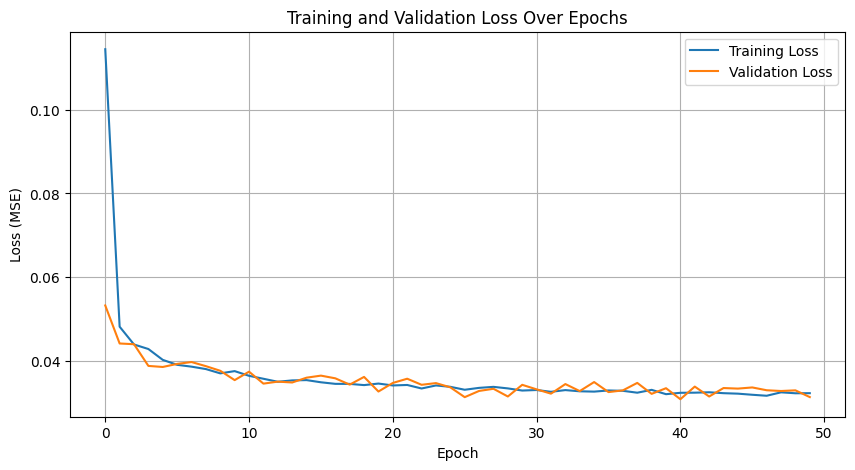

In [21]:
from torchvision.utils import save_image, make_grid
import time

# --- Lists to store losses ---
train_losses = []
val_losses = [] # Optional: if validation is performed

print(f"Starting training for {EPOCHS} epochs...")

start_time = time.time()

for epoch in range(EPOCHS):
    epoch_start_time = time.time()
    model.train() # Ensure model is in training mode
    total_epoch_loss = 0.0

    # --- Training Phase ---
    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS} [Training]", leave=False)
    for step, batch in enumerate(pbar):
        optimizer.zero_grad() # Clear gradients

        # Use the training_step function from Cell 17
        loss = training_step(batch, model, loss_type="mse")

        loss.backward() # Compute gradients

        # Optional: Gradient Clipping
        if GRADIENT_CLIP_VALUE is not None:
            torch.nn.utils.clip_grad_norm_(model.parameters(), GRADIENT_CLIP_VALUE)

        optimizer.step() # Update model parameters

        total_epoch_loss += loss.item()
        pbar.set_postfix({"Loss": loss.item()}) # Update progress bar description

    avg_train_loss = total_epoch_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # --- Validation Phase (Optional but Recommended) ---
    model.eval() # Set model to evaluation mode
    total_val_loss = 0.0
    with torch.no_grad(): # Disable gradient calculations
        pbar_val = tqdm(val_loader, desc=f"Epoch {epoch+1}/{EPOCHS} [Validation]", leave=False)
        for batch in pbar_val:
            # Can reuse training_step or call p_losses directly
            # Reusing training_step is fine as it handles device placement and sampling t
            val_loss = training_step(batch, model, loss_type="mse")
            total_val_loss += val_loss.item()
            pbar_val.set_postfix({"Val Loss": val_loss.item()})

    avg_val_loss = total_val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    epoch_end_time = time.time()
    epoch_duration = epoch_end_time - epoch_start_time

    print(f"Epoch {epoch+1}/{EPOCHS} | Time: {epoch_duration:.2f}s | "
          f"Avg Train Loss: {avg_train_loss:.4f} | Avg Val Loss: {avg_val_loss:.4f}")

    # --- Generate and Save Samples ---
    if (epoch + 1) % SAMPLE_INTERVAL == 0 or epoch == EPOCHS - 1:
        print(f"--- Generating samples for epoch {epoch+1} ---")
        model.eval() # Ensure model is in eval mode for sampling
        num_samples = 16 # Generate a 4x4 grid
        sample_shape = (N_CHANNELS, IMG_SIZE, IMG_SIZE)

        # Prepare labels for conditional sampling (if applicable)
        sample_labels = None
        if model.num_classes is not None:
            # Sample 16 random labels from 0 to num_classes-1
            sample_labels = torch.randint(0, model.num_classes, (num_samples,), device=device)

        generated_images = p_sample_loop(model, sample_shape, num_samples, class_labels=sample_labels)

        # Save the grid of generated images
        grid = make_grid(generated_images, nrow=4) # Arrange in a 4x4 grid
        sample_filename = SAMPLES_DIR / f"epoch_{(epoch+1):03d}.png"
        save_image(grid, sample_filename)
        print(f"Saved sample grid to {sample_filename}")

        # Display the grid (optional, seemed a bit unstabled during testing)
        # plt.figure(figsize=(6,6))
        # plt.imshow(grid.permute(1, 2, 0).cpu()) # Need to move to CPU and change dim order
        # plt.axis('off')
        # plt.title(f"Samples Epoch {epoch+1}")
        # plt.show()


# --- End of Training ---
total_training_time = time.time() - start_time
print(f"\n--- Training Finished ---")
print(f"Total Training Time: {total_training_time:.2f} seconds")

# --- Save the final model ---
torch.save(model.state_dict(), MODEL_SAVE_PATH)
print(f"Final model state dict saved to {MODEL_SAVE_PATH}")

# --- Plot Losses ---
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)
plt.show()


## Load Trained Model

In [22]:
# --- Load the Trained Model State ---
# This is useful if you want to evaluate later or if the kernel restarted

# Ensure the model architecture is defined (run Cell 10/17 if needed)
# Ensure model hyperparameters match the saved model
# (unet_base_dim, unet_dim_mults, unet_time_emb_dim, unet_num_classes)

# Instantiate a new model instance or use the existing one
# If using the existing 'model' variable, ensure it's the correct architecture
# If creating a new one:
# model_eval = UNet(
#     in_channels=N_CHANNELS,
#     out_channels=N_CHANNELS,
#     base_dim=unet_base_dim,
#     dim_mults=unet_dim_mults,
#     time_emb_dim=unet_time_emb_dim,
#     num_classes=unet_num_classes, # Make sure this matches the trained model
#     num_groups=8
# ).to(device)

# Use the existing model variable if it's still in memory from training
model_eval = model # Assuming 'model' holds the trained instance

# Load the saved state dictionary
model_save_path_load = MODEL_SAVE_PATH # From Cell 19
if model_save_path_load.exists():
    try:
        model_eval.load_state_dict(torch.load(model_save_path_load, map_location=device))
        model_eval.eval() # Set to evaluation mode
        print(f"Successfully loaded trained model state from: {model_save_path_load}")
    except Exception as e:
        print(f"Error loading model state from {model_save_path_load}: {e}")
        print("Ensure the current model architecture matches the saved state.")
        # If loading fails, the 'model_eval' might still hold the last state from training
        # Or you might need to reinstantiate and load carefully
else:
    print(f"Model state file not found at {model_save_path_load}. Using model state from end of training.")
    # Ensure the model used for evaluation is the one from the end of training
    model_eval.eval()



Successfully loaded trained model state from: cifar10_diffusion_model.pth


## Visualize Final Generated Samples

Displaying final sample grid from: generated_samples/epoch_050.png


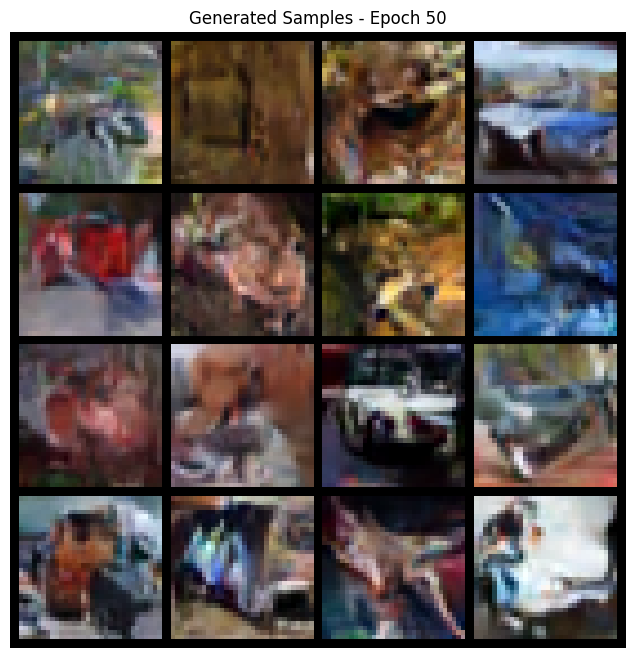

In [23]:
import matplotlib.pyplot as plt
from PIL import Image
import os

# --- Load and Display the Final Sample Grid ---
final_epoch = EPOCHS # The last epoch number
final_sample_filename = SAMPLES_DIR / f"epoch_{final_epoch:03d}.png"

if final_sample_filename.exists():
    print(f"Displaying final sample grid from: {final_sample_filename}")
    final_grid_img = Image.open(final_sample_filename)

    plt.figure(figsize=(8, 8)) # Adjust size as needed
    plt.imshow(final_grid_img)
    plt.title(f"Generated Samples - Epoch {final_epoch}")
    plt.axis('off')
    plt.show()
else:
    print(f"Final sample grid {final_sample_filename} not found.")
    print("Consider running the generation code below or check the training output.")



## Generate and Visualize Samples for Specific Classes



Generating samples for specific classes (0-9)...
Generating 40 samples (4 per class)...
Generating 40 images with conditioning on labels: [0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3, 4, 4, 4, 4, 5, 5, 5, 5, 6, 6, 6, 6, 7, 7, 7, 7, 8, 8, 8, 8, 9, 9, 9, 9]


Sampling loop:   0%|          | 0/1000 [00:00<?, ?it/s]

Saved specific class sample grid to generated_samples/specific_class_samples.png


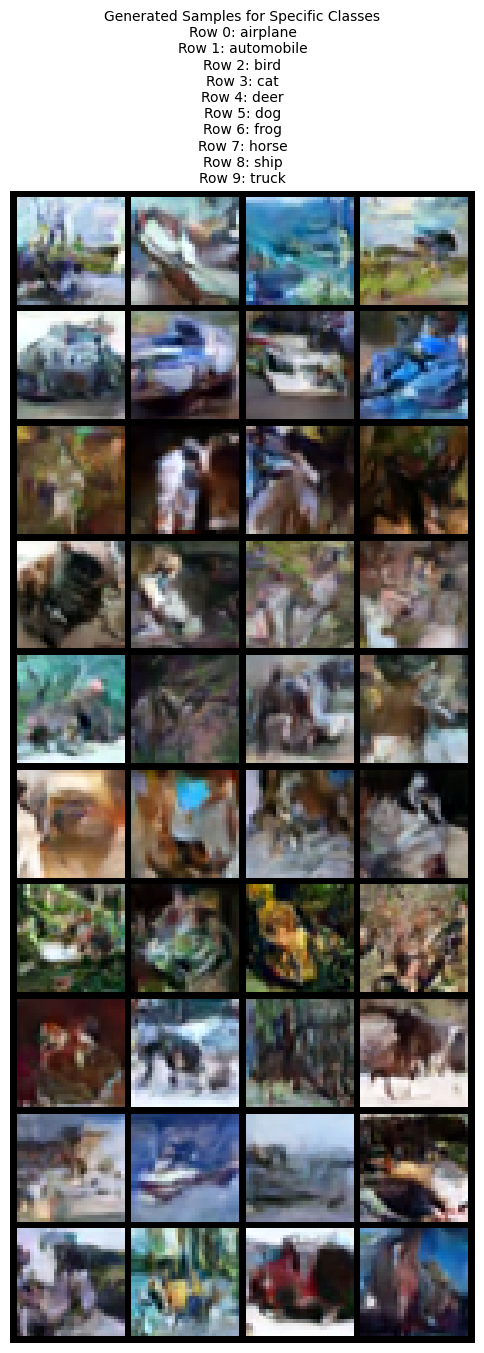

In [24]:
# --- Generate Samples for Specific Classes (Conditional Model Only) ---

if model_eval.num_classes is None:
    print("Model is unconditional. Skipping specific class generation.")
else:
    print(f"\nGenerating samples for specific classes (0-{model_eval.num_classes-1})...")
    num_classes_to_show = model_eval.num_classes
    samples_per_class = 4 # Generate N samples for each class
    total_specific_samples = num_classes_to_show * samples_per_class

    # Create labels: [0, 0, 0, 0, 1, 1, 1, 1, 2, 2, ...]
    specific_labels = torch.repeat_interleave(
        torch.arange(num_classes_to_show, device=device),
        samples_per_class
    ).long()

    sample_shape = (N_CHANNELS, IMG_SIZE, IMG_SIZE)

    print(f"Generating {total_specific_samples} samples ({samples_per_class} per class)...")
    # Use the loaded evaluation model
    specific_generated_images = p_sample_loop(
        model_eval, sample_shape, total_specific_samples, class_labels=specific_labels
    )

    # Create and display the grid
    specific_grid = make_grid(specific_generated_images, nrow=samples_per_class) # Arrange by class

    # Save the specific grid (optional)
    specific_grid_filename = SAMPLES_DIR / "specific_class_samples.png"
    save_image(specific_grid, specific_grid_filename)
    print(f"Saved specific class sample grid to {specific_grid_filename}")

    # Display
    plt.figure(figsize=(samples_per_class * 1.5, num_classes_to_show * 1.5)) # Adjust size
    plt.imshow(specific_grid.permute(1, 2, 0).cpu()) # Permute CHW -> HWC for display
    # Add class labels as title (simplified)
    class_titles = "\n".join([f"Row {i}: {cifar10_classes[i]}" for i in range(num_classes_to_show)])
    plt.title(f"Generated Samples for Specific Classes\n{class_titles}", fontsize=10)
    plt.axis('off')
    plt.show()



## Visualize Training Progression


Visualizing sample generation progress...
Displaying samples from epochs: ['epoch_005.png', 'epoch_010.png', 'epoch_020.png', 'epoch_030.png', 'epoch_040.png', 'epoch_050.png']


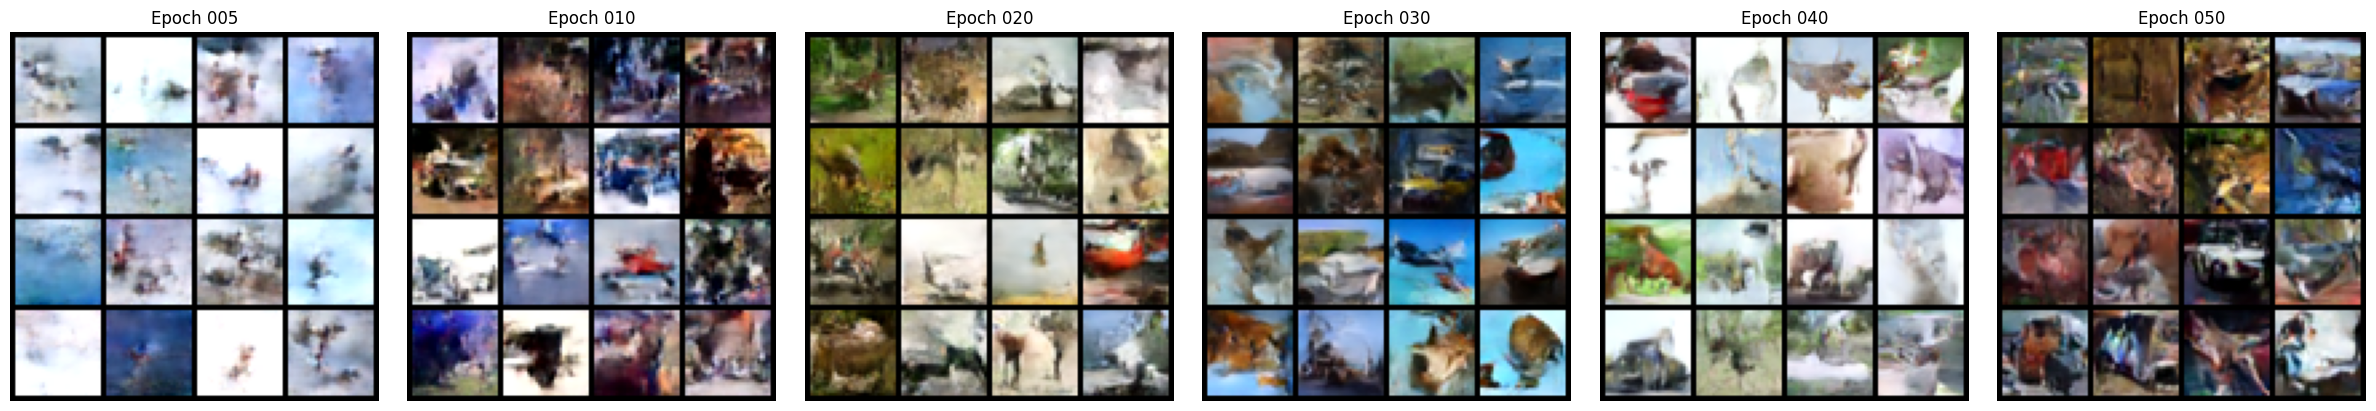

In [25]:
import glob # To find multiple sample files

# --- Visualize Sample Evolution Over Epochs ---
print("\nVisualizing sample generation progress...")

# Find saved sample files matching the pattern
sample_files = sorted(glob.glob(os.path.join(SAMPLES_DIR, "epoch_*.png")))

if not sample_files:
    print("No sample files found in", SAMPLES_DIR)
else:
    # Select a subset of epochs to display (e.g., first, middle, last, and some in between)
    num_files = len(sample_files)
    # Aim for ~5-6 images spanning the training
    indices_to_show = np.linspace(0, num_files - 1, num=min(num_files, 6), dtype=int)
    files_to_show = [sample_files[i] for i in indices_to_show]

    print(f"Displaying samples from epochs: {[os.path.basename(f) for f in files_to_show]}")

    num_show = len(files_to_show)
    plt.figure(figsize=(num_show * 4, 4)) # Adjust size as needed

    for i, f_path in enumerate(files_to_show):
        epoch_num = os.path.basename(f_path).replace("epoch_", "").replace(".png", "")
        img = Image.open(f_path)
        plt.subplot(1, num_show, i + 1)
        plt.imshow(img)
        plt.title(f"Epoch {epoch_num}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()



## Re-plot Loss Curve

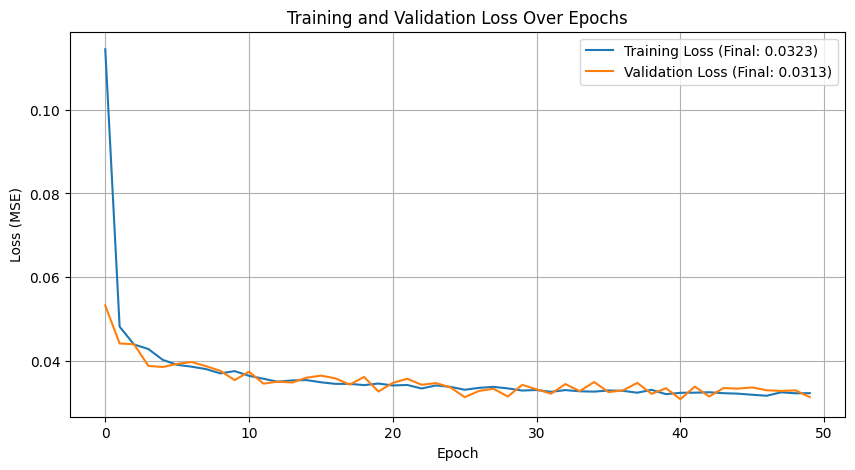

In [26]:
# --- Plot Final Loss Curves ---
# (This repeats the plotting from the end of Cell 20, but is useful for organization)

if train_losses and val_losses: # Check if loss lists exist and are not empty
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label=f'Training Loss (Final: {train_losses[-1]:.4f})')
    plt.plot(val_losses, label=f'Validation Loss (Final: {val_losses[-1]:.4f})')
    plt.title('Training and Validation Loss Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss (MSE)')
    plt.legend()
    plt.grid(True)
    # Optional: Save the plot
    # plt.savefig(SAMPLES_DIR / "loss_curve.png")
    plt.show()
else:
    print("Loss data (train_losses/val_losses) not found. Cannot plot loss curve.")



# CLIP Evaluation (Optional - Bonus 10%)
- Set up the CLIP model for image evaluation
- Analyze generated images using CLIP scores

## Install and Import CLIP

In [28]:
# Install the CLIP library from OpenAI if you haven't already
!pip install ftfy regex tqdm
!pip install git+https://github.com/openai/CLIP.git
# Or using pip directly if available:
# !pip install clip-openai

import clip
import torch
from PIL import Image
import os
import glob # To find generated image files
from torchvision.transforms.functional import to_pil_image # To convert tensors to PIL
from tqdm.auto import tqdm

print("CLIP library imported.")

# Check if CLIP is available and list models
try:
    available_models = clip.available_models()
    print("Available CLIP models:", available_models)
except Exception as e:
    print(f"Could not check CLIP models. Is the library installed correctly? Error: {e}")

# Ensure device is defined (should be from previous cells)
if 'device' not in locals():
     device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 4.1 MB/s eta 0:00:00
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-sv1ozeeu
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-sv1ozeeu
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 114.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 83.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 57.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 35.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━

## Load CLIP Model

In [29]:
# --- Load CLIP Model ---
# Common choices: "ViT-B/32", "ViT-B/16". Larger models like "ViT-L/14" are more powerful but need more VRAM.
clip_model_name = "ViT-B/32"
try:
    clip_model, clip_preprocess = clip.load(clip_model_name, device=device)
    clip_model.eval() # Set CLIP model to evaluation mode
    print(f"CLIP model '{clip_model_name}' loaded successfully on {device}.")
    print("CLIP Image Preprocessor:", clip_preprocess)
except Exception as e:
    print(f"Error loading CLIP model '{clip_model_name}': {e}")
    print("Please ensure the model name is correct and the library is installed.")
    clip_model = None # Set to None if loading failed


100%|███████████████████████████████████████| 338M/338M [00:04<00:00, 79.7MiB/s]


CLIP model 'ViT-B/32' loaded successfully on cuda.
CLIP Image Preprocessor: Compose(
    Resize(size=224, interpolation=bicubic, max_size=None, antialias=True)
    CenterCrop(size=(224, 224))
    <function _convert_image_to_rgb at 0x79e675c2af20>
    ToTensor()
    Normalize(mean=(0.48145466, 0.4578275, 0.40821073), std=(0.26862954, 0.26130258, 0.27577711))
)


## Prepare Text Prompts for CIFAR-10

In [30]:
# --- Define CIFAR-10 Classes (should match dataset) ---
cifar10_classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
                   'dog', 'frog', 'horse', 'ship', 'truck']

# --- Create Text Prompts ---
# Using a simple template. More sophisticated templates might yield slightly different results.
text_prompts = [f"a photo of a {label}" for label in cifar10_classes]
print("Text prompts created:")
for i, p in enumerate(text_prompts):
    print(f"{i}: {p}")

# --- Tokenize and Encode Text Prompts ---
if clip_model is not None:
    with torch.no_grad(): # No gradients needed for text encoding
        text_tokens = clip.tokenize(text_prompts).to(device)
        text_features = clip_model.encode_text(text_tokens)
        # Normalize text features (important for cosine similarity)
        text_features /= text_features.norm(dim=-1, keepdim=True)
        print(f"\nEncoded and normalized text features shape: {text_features.shape}") # Should be [10, embedding_dim]
else:
    print("\nCLIP model not loaded. Cannot encode text features.")
    text_features = None



Text prompts created:
0: a photo of a airplane
1: a photo of a automobile
2: a photo of a bird
3: a photo of a cat
4: a photo of a deer
5: a photo of a dog
6: a photo of a frog
7: a photo of a horse
8: a photo of a ship
9: a photo of a truck

Encoded and normalized text features shape: torch.Size([10, 512])


## Load or Generate Images for Evaluation

In [31]:
# --- Option 1: Load Saved Samples ---
# Load images generated during training (e.g., the last saved sample grid)
EVAL_EPOCH = EPOCHS # Evaluate the samples generated at the final epoch
sample_filename = SAMPLES_DIR / f"epoch_{EVAL_EPOCH:03d}.png"
num_eval_samples = 16 # Should match the number of samples saved in the grid

generated_images_for_eval = []
if sample_filename.exists():
    print(f"Loading saved sample grid: {sample_filename}")
    # Load the entire grid image
    grid_img = Image.open(sample_filename).convert("RGB")

    # Split the grid back into individual images (assuming nrow=4 for a 16-image grid)
    grid_w, grid_h = grid_img.size
    img_w = grid_w // 4
    img_h = grid_h // 4
    for i in range(4): # row
        for j in range(4): # col
            box = (j * img_w, i * img_h, (j + 1) * img_w, (i + 1) * img_h)
            individual_img = grid_img.crop(box)
            generated_images_for_eval.append(individual_img)
    print(f"Loaded {len(generated_images_for_eval)} individual images from the grid.")
    # Note: We don't know the *intended* class labels for these saved samples unless
    # we saved that information separately or regenerate them with known labels.
    # For simplicity here, we'll treat them as if evaluating general quality.
    intended_labels_for_eval = None # Set to None if labels are unknown

else:
    print(f"Sample file {sample_filename} not found. Generating new samples...")
    # --- Option 2: Generate New Samples ---
    num_eval_samples = 16 # How many new images to generate
    sample_shape = (N_CHANNELS, IMG_SIZE, IMG_SIZE)
    intended_labels_for_eval = None
    if model.num_classes is not None:
        # Generate samples for specific classes (e.g., 2 of each for first 8 classes)
        # intended_labels_for_eval = torch.tensor([i // 2 for i in range(num_eval_samples)], device=device).long()
        # Or just random labels
        intended_labels_for_eval = torch.randint(0, model.num_classes, (num_eval_samples,), device=device)
        print("Generating new conditional samples with labels:", intended_labels_for_eval.tolist())
    else:
        print(f"Generating {num_eval_samples} new unconditional samples.")

    # Generate images using the diffusion model's sampling loop
    generated_tensors = p_sample_loop(model, sample_shape, num_eval_samples, class_labels=intended_labels_for_eval)
    # Convert generated tensors [0, 1] to PIL Images
    generated_images_for_eval = [to_pil_image(img_tensor) for img_tensor in generated_tensors.cpu()]
    print(f"Generated {len(generated_images_for_eval)} new images.")

# --- Verify we have images ---
if not generated_images_for_eval:
    print("ERROR: No images found or generated for evaluation.")
else:
    print(f"Proceeding to evaluate {len(generated_images_for_eval)} images.")



Loading saved sample grid: generated_samples/epoch_050.png
Loaded 16 individual images from the grid.
Proceeding to evaluate 16 images.


## Preprocess Images and Calculate CLIP Scores

In [32]:
# --- Preprocess Images and Compute Embeddings ---
image_features_list = []
batch_size_clip = 64 # Process images in batches for CLIP if many images

if clip_model is not None and generated_images_for_eval:
    print(f"Preprocessing images and computing CLIP features...")
    num_batches = (len(generated_images_for_eval) + batch_size_clip - 1) // batch_size_clip

    with torch.no_grad():
        for i in tqdm(range(num_batches), desc="CLIP Image Encoding"):
            batch_start = i * batch_size_clip
            batch_end = min((i + 1) * batch_size_clip, len(generated_images_for_eval))
            image_batch_pil = generated_images_for_eval[batch_start:batch_end]

            # Apply CLIP preprocessing to each image in the batch
            image_input_batch = torch.stack([clip_preprocess(img) for img in image_batch_pil]).to(device)

            # Compute image features
            batch_features = clip_model.encode_image(image_input_batch)
            # Normalize image features
            batch_features /= batch_features.norm(dim=-1, keepdim=True)
            image_features_list.append(batch_features)

    # Concatenate features from all batches
    image_features = torch.cat(image_features_list, dim=0)
    print(f"Computed and normalized image features shape: {image_features.shape}") # Should be [num_eval_samples, embedding_dim]

    # --- Calculate Cosine Similarities ---
    # image_features: [num_eval_samples, embedding_dim]
    # text_features: [num_classes, embedding_dim]
    # Similarity = image_features @ text_features.T -> [num_eval_samples, num_classes]
    similarity_matrix = (image_features @ text_features.T) # Using matrix multiplication for efficiency
    print(f"Calculated similarity matrix shape: {similarity_matrix.shape}")

else:
    print("CLIP model not loaded or no images to evaluate. Skipping score calculation.")
    similarity_matrix = None



Preprocessing images and computing CLIP features...


CLIP Image Encoding:   0%|          | 0/1 [00:00<?, ?it/s]

Computed and normalized image features shape: torch.Size([16, 512])
Calculated similarity matrix shape: torch.Size([16, 10])


## Analyze CLIP Scores

In [33]:
if similarity_matrix is not None:
    print("\n--- CLIP Score Analysis ---")

    # Convert similarity matrix to probabilities (optional, but common)
    # probs = similarity_matrix.softmax(dim=-1)

    # Find the best matching text prompt for each image
    # values are the similarity scores, indices are the class indices (0-9)
    best_match_scores, best_match_indices = similarity_matrix.max(dim=-1)

    # 1. Average Top-1 Similarity Score
    avg_top1_similarity = best_match_scores.mean().item()
    print(f"Average Top-1 Similarity (Image to Best Matching Text): {avg_top1_similarity:.4f}")

    # 2. Matching Accuracy (only if intended labels are known)
    if intended_labels_for_eval is not None:
        intended_labels_tensor = intended_labels_for_eval.to(best_match_indices.device) # Ensure device match
        # Check if the index of the best matching text prompt equals the intended label
        correct_matches = (best_match_indices == intended_labels_tensor).float()
        matching_accuracy = correct_matches.mean().item()
        print(f"CLIP Matching Accuracy (Best Text Match == Intended Label): {matching_accuracy:.4f}")

        # 3. Average Similarity to Intended Class (only if intended labels are known)
        # Gather the similarity score specifically for the intended class of each image
        similarity_to_intended = similarity_matrix[torch.arange(len(intended_labels_tensor)), intended_labels_tensor]
        avg_similarity_to_intended = similarity_to_intended.mean().item()
        print(f"Average Similarity (Image to Intended Class Text): {avg_similarity_to_intended:.4f}")

    else:
        print("Intended labels not available, skipping Matching Accuracy and Intended Similarity calculation.")

    # --- Display some results (optional) ---
    num_to_show = min(5, len(generated_images_for_eval)) # Show top 5 examples
    print(f"\nTop {num_to_show} Examples (Best Matching Text):")
    for i in range(num_to_show):
        img_label_index = best_match_indices[i].item()
        img_label_name = cifar10_classes[img_label_index]
        score = best_match_scores[i].item()
        intended_info = ""
        if intended_labels_for_eval is not None:
             intended_idx = intended_labels_for_eval[i].item()
             intended_name = cifar10_classes[intended_idx]
             intended_info = f" (Intended: {intended_name})"
        print(f"  Image {i}: Best match = '{img_label_name}'{intended_info}, Score = {score:.3f}")

        # You could also display the images here using matplotlib if desired
        # plt.imshow(generated_images_for_eval[i])
        # plt.title(f"Best: {img_label_name} ({score:.3f}){intended_info}")
        # plt.show()

else:
    print("Similarity matrix not calculated. Cannot analyze scores.")




--- CLIP Score Analysis ---
Average Top-1 Similarity (Image to Best Matching Text): 0.2351
Intended labels not available, skipping Matching Accuracy and Intended Similarity calculation.

Top 5 Examples (Best Matching Text):
  Image 0: Best match = 'horse', Score = 0.235
  Image 1: Best match = 'dog', Score = 0.220
  Image 2: Best match = 'dog', Score = 0.235
  Image 3: Best match = 'airplane', Score = 0.228
  Image 4: Best match = 'automobile', Score = 0.261


## Visualize Images with Best Matching CLIP Labels


--- Visualizing Generated Images and Best CLIP Matches ---


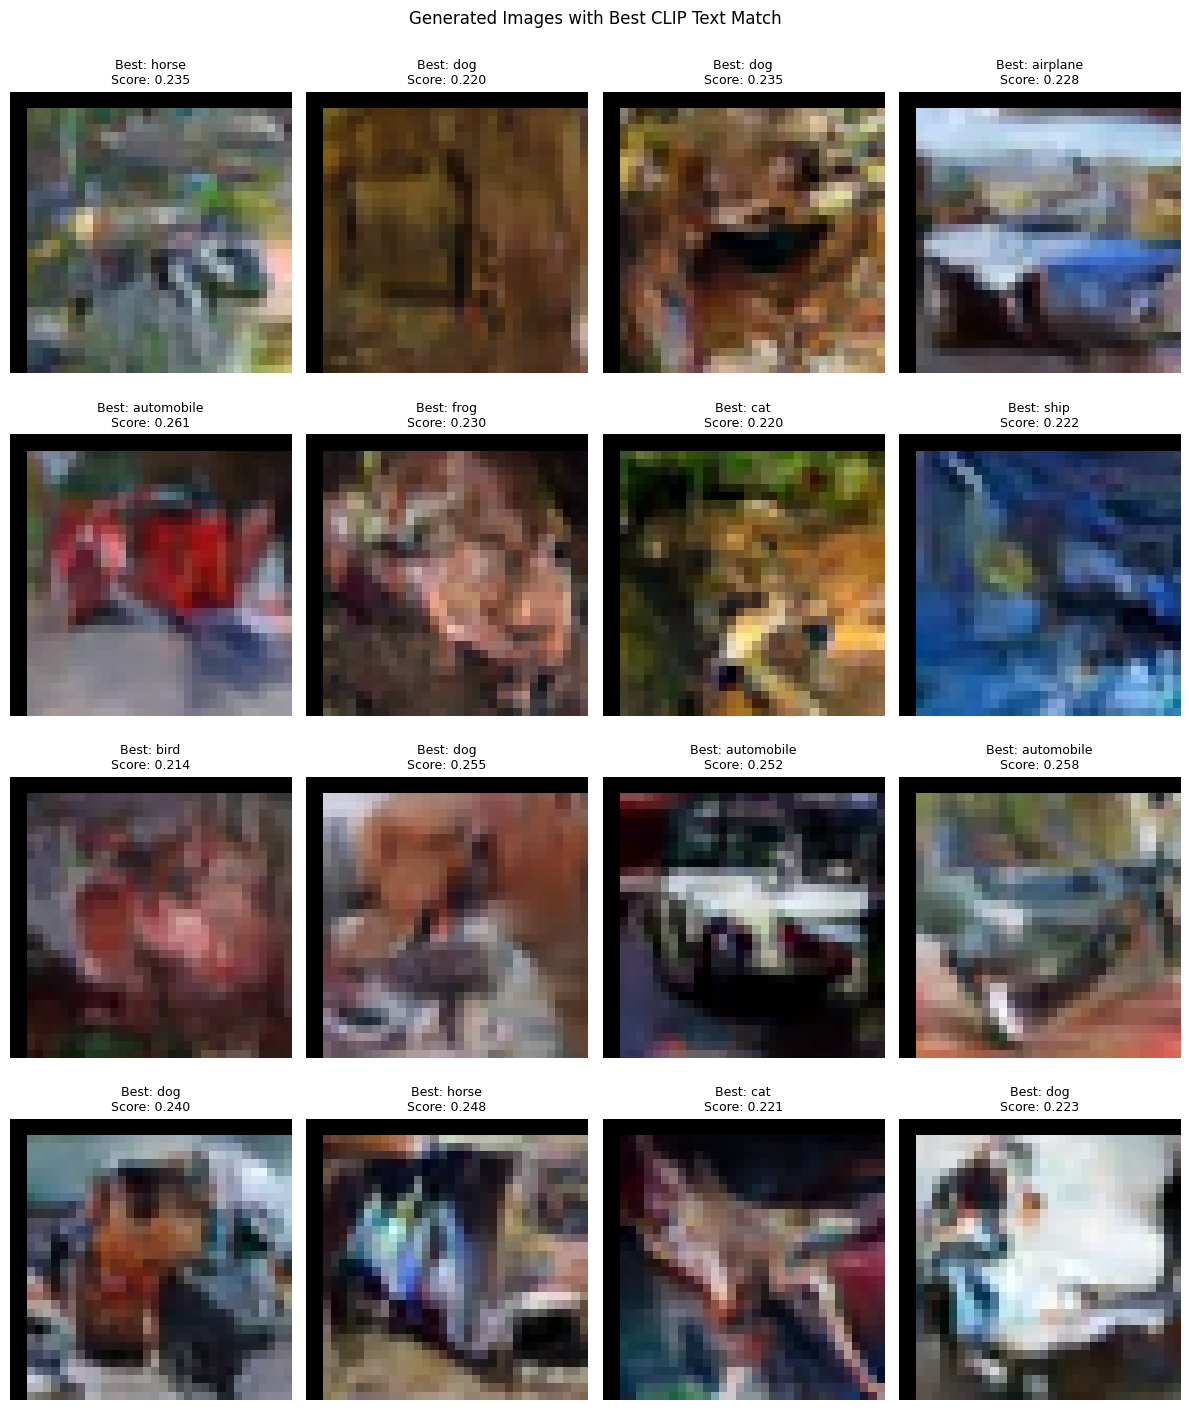

In [34]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

# --- Visualize Generated Images with CLIP's Best Guess ---

if 'similarity_matrix' in locals() and similarity_matrix is not None and generated_images_for_eval:
    print("\n--- Visualizing Generated Images and Best CLIP Matches ---")

    # Get best matches again (if not already available)
    if 'best_match_scores' not in locals() or 'best_match_indices' not in locals():
         best_match_scores, best_match_indices = similarity_matrix.max(dim=-1)

    num_images_to_visualize = min(16, len(generated_images_for_eval)) # Show up to 16 images
    num_cols = 4
    num_rows = (num_images_to_visualize + num_cols - 1) // num_cols

    plt.figure(figsize=(num_cols * 3, num_rows * 3.5)) # Adjust size as needed

    for i in range(num_images_to_visualize):
        img = generated_images_for_eval[i]
        best_idx = best_match_indices[i].item()
        best_label = cifar10_classes[best_idx]
        best_score = best_match_scores[i].item()

        # Determine intended label info if available
        intended_info = ""
        is_match = ""
        if intended_labels_for_eval is not None:
             intended_idx = intended_labels_for_eval[i].item()
             intended_name = cifar10_classes[intended_idx]
             intended_info = f"\n(Intended: {intended_name})"
             if intended_idx == best_idx:
                 is_match = " [MATCH]"
             else:
                 is_match = " [MISMATCH]"


        plt.subplot(num_rows, num_cols, i + 1)
        plt.imshow(img)
        plt.title(f"Best: {best_label}{is_match}\nScore: {best_score:.3f}{intended_info}", fontsize=9)
        plt.axis('off')

    plt.tight_layout()
    plt.suptitle("Generated Images with Best CLIP Text Match", y=1.02) # Add overall title
    plt.show()

else:
    print("Skipping visualization: CLIP results or generated images not available.")



## Visualize Similarity Matrix Heatmap


--- Visualizing Image-Text Similarity Matrix ---


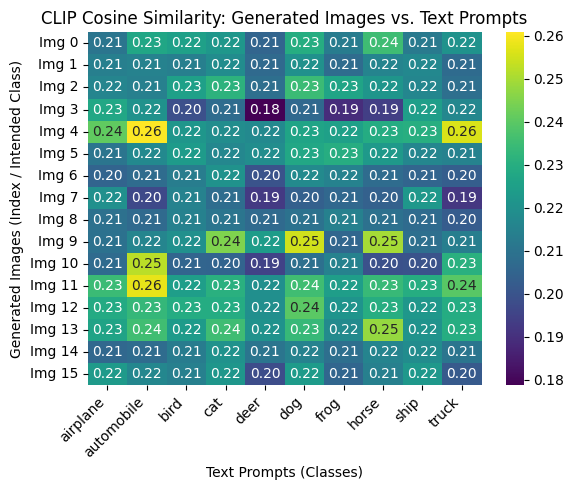

In [35]:
import seaborn as sns # For prettier heatmaps

# --- Visualize the Full Similarity Matrix ---

if 'similarity_matrix' in locals() and similarity_matrix is not None:
    print("\n--- Visualizing Image-Text Similarity Matrix ---")

    # Move matrix to CPU for plotting
    similarity_matrix_cpu = similarity_matrix.cpu().numpy()

    num_eval_samples = similarity_matrix_cpu.shape[0]
    num_classes = similarity_matrix_cpu.shape[1]

    plt.figure(figsize=(max(6, num_classes * 0.6), max(5, num_eval_samples * 0.3))) # Adjust size

    # Create y-axis labels (Image indices, potentially with intended class)
    y_labels = [f"Img {i}" for i in range(num_eval_samples)]
    if intended_labels_for_eval is not None:
        y_labels = [f"Img {i} ({cifar10_classes[intended_labels_for_eval[i].item()]})" for i in range(num_eval_samples)]


    sns.heatmap(
        similarity_matrix_cpu,
        annot=True, # Show similarity values
        fmt=".2f",  # Format values to 2 decimal places
        cmap="viridis", # Colormap (others: "hot", "coolwarm", etc.)
        xticklabels=cifar10_classes, # Class names for columns
        yticklabels=y_labels # Image indices/labels for rows
    )
    plt.xlabel("Text Prompts (Classes)")
    plt.ylabel("Generated Images (Index / Intended Class)")
    plt.title("CLIP Cosine Similarity: Generated Images vs. Text Prompts")
    plt.xticks(rotation=45, ha='right') # Rotate x-axis labels for readability
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

else:
    print("Skipping heatmap visualization: Similarity matrix not available.")

